In [130]:
# Lynette Davis
# CS Independent Study
# Multibeam Sonar Data Analysis
# University of New Hampshire


%matplotlib inline
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import nbresuse
import numpy as np
import os
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pyproj import Proj
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import seaborn as sns
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import statistics
import verde as vd
import sys


def print_stats(d):
    print("Min: %f"%(np.min(d)))
    print("Max: %f"%(np.max(d)))
    print("Range: %f"%(np.max(d) - np.min(d)))
    print("5th percentile: %f"%(np.percentile(d, 5)))
    print("10th percentile: %f"%(np.percentile(d, 10)))
    print("25th percentile: %f"%(np.percentile(d, 25)))
    print("50th percentile: %f"%(np.percentile(d, 50)))
    print("75th percentile: %f"%(np.percentile(d, 75)))
    print("90th percentile: %f"%(np.percentile(d, 90)))
    print("95th percentile: %f"%(np.percentile(d, 95)))

def full_rbf_analysis(x_raw, y_raw, z_raw, x_clean, y_clean, z_clean, reg_grid_x, reg_grid_y,
                      extent, vmin, vmax, tvu, function='multiquadric', smooth=0.0):
    # Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb

    # TODO: "Ill-conditioned matrix" warning... Resolved when restarting Pycharm/Kernel.
    # TODO: This warning appears intermittently, is it just related to luck-of-the-draw when subsampling data?
    # Interpolate (radial basis function) subsampled data:
    # Make and n-dimensional interpolator:
    rbfi= Rbf(x_raw, y_raw, z_raw, function=function, smooth=smooth)
    # Predict on the regular grid:
    rbfi_di = rbfi(reg_grid_x, reg_grid_y)

    print("Interpolated (RBF=%s, Smooth=%.2f), Subsampled, Raw Data:\n"%(function, smooth))
    print_stats(rbfi_di)

    # Plot interpolated, subsampled raw data (predicted on regular grid):
    fig, ax = plt.subplots(figsize=(15,15))
    c1 = plt.imshow(rbfi_di.T, origin="lower", extent=extent, vmin=vmin, vmax=vmax)
    #c2 = plt.scatter(x_sub_raw, y_sub_raw, s=20, c=z_sub_raw, edgecolor='w', vmin=data["depth"].min(), vmax=data["depth"].max())
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("Interpolated (RBF=%s, Smooth=%.2f), Subsampled, Raw Data"%(function, smooth), fontsize=20)
    plt.colorbar(c1, shrink=0.2);

    # For testing:
    # --------------------------------------------------
    # Apply radial basis function interpolator created for subsampled, raw data
    # to the data points associated with subsampled, raw data:
    depth_hat_sub_raw = rbfi(x_raw, y_raw)
    error = depth_hat_sub_raw - z_raw

    # Plot result:
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.scatter(x_raw, y_raw, c=error, vmin=-tvu, vmax=tvu)
    # set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
    ax.set_aspect(1)
    # Disable scientific notation of axes ticks:
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("ERROR: Interpolated (RBF=%s, Smooth=%.2f) Raw Data at Raw Data Points"%(function, smooth), fontsize=20)
    ax.grid(c='k', alpha=0.2)
    cb = fig.colorbar(im, shrink=0.2)

    # Histogram for error between interpolated, subsampled raw data and subsampled, cleaned data:
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.hist(error, bins=(int((np.max(depth_hat_sub_raw) - np.min(depth_hat_sub_raw)) / 2)))
    plt.hist(error, bins=(50))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Depth Error (m)")
    ax.set_ylabel("Count")
    ax.set_title("ERROR: Interpolated (RBF=%s, Smooth %.2f) Raw Data at Raw Data Points"%(function, smooth), fontsize=20)

    print("\nERROR: Interpolated (RBF=%s, Smooth %.2f) Raw Data at Raw Data Points"%(function, smooth))
    print("Mean: %f"%(statistics.mean(error)))
    print("Standard Deviation: %f"%(statistics.stdev(error)))

    # --------------------------------------------------
    # Apply radial basis function interpolator created for subsampled, raw data
    # to the data points associated with subsampled, clean data:
    depth_hat_sub_raw = rbfi(x_clean, y_clean)
    error = depth_hat_sub_raw - z_clean

    # Plot result:
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.scatter(x_clean, y_clean, c=error, vmin=-tvu, vmax=tvu)
    # set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
    ax.set_aspect(1)
    # Disable scientific notation of axes ticks:
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("Error: Interpolated (RBF=%s, Smooth=%.2f) Raw Data at Clean Data Points"%(function, smooth), fontsize=20)
    ax.grid(c='k', alpha=0.2)
    cb = fig.colorbar(im, shrink=0.2)

    # Histogram for error between interpolated, subsampled raw data and subsampled, cleaned data:
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.hist(error, bins=(int((np.max(depth_hat_sub_raw) - np.min(depth_hat_sub_raw)) / 2)))
    plt.hist(error, bins=(50))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Depth Error (m)")
    ax.set_ylabel("Count")
    ax.set_title("Error: Interpolated (RBF=%s, Smooth=%.2f) Raw Data at Clean Data Points"%(function, smooth), fontsize=20)

    print("\nERROR: Interpolated (RBF=%s, Smooth %.2f) Raw Data at Clean Data Points"%(function, smooth))
    print("Mean: %f"%(statistics.mean(error)))
    print("Standard Deviation: %f"%(statistics.stdev(error)))

def full_gaussian_process_regressor_RBF(x_raw, y_raw, z_raw, x_clean, y_clean, z_clean, reg_grid_x, reg_grid_y, extent,
                                   vmin, vmax, tvu, alpha=0.1, length_scale=0.01):
    # Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb

    # RBF = Radial Basis Function

    points_raw = np.array([x_raw.tolist(), y_raw.tolist()]).T

    # NOTE: Default value of length_scale=1, and customized value of length_scale=0.1 produces warning:
    # ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to
    # the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
    kernel = RBF(length_scale=length_scale)

    # Larger alpha values imply more noise in the input data
    gp = GaussianProcessRegressor(normalize_y=True, alpha=alpha, kernel=kernel)

    gp.fit(points_raw, z_raw)
    x_grid = np.stack([reg_grid_x.ravel(), reg_grid_y.ravel()]).T
    y_grid = gp.predict(x_grid).reshape(reg_grid_x.shape)

    #%%
    fig, ax = plt.subplots(figsize=(15,15))
    im = plt.imshow(y_grid.T, origin="lower", extent=extent, vmin=vmin, vmax=vmax)
    #pts = plt.scatter(x_sub_raw, y_sub_raw, c=z_sub_raw, s=80, edgecolors='w', vmin=data["depth"].min(), vmax=data["depth"].max())
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("Interpolated (RBF, Gaussian Process Regressor), Subsampled, Raw Data "
                 "\n(alpha=%.2f, length_scale=%.2f)"%(alpha, length_scale))
    fig.colorbar(im, shrink=0.2);

    # For testing:
    # --------------------------------------------------
    # Apply gaussian process regressor (RBF) interpolator created for subsampled, raw data
    # to the data points associated with subsampled, raw data:
    depth_hat = gp.predict(points_raw)
    error = depth_hat - z_raw

    # Plot result:
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.scatter(x_raw, y_raw, c=error, vmin=-tvu, vmax=tvu)
    # set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
    ax.set_aspect(1)
    # Disable scientific notation of axes ticks:
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("Error: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Raw Data Points "
                 "\n(alpha=%.2f, length_scale=%.2f)"%(alpha, length_scale), fontsize=20)
    ax.grid(c='k', alpha=0.2)
    cb = fig.colorbar(im, shrink=0.2);

    # Histogram for error between interpolated, subsampled raw data and subsampled, cleaned data:
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.hist(error, bins=(int((np.max(depth_hat_sub_raw) - np.min(depth_hat_sub_raw)) / 2)))
    plt.hist(error, bins=(50))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Depth Error (m)")
    ax.set_ylabel("Count")
    ax.set_title("Error: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Raw Data Points "
                 "\n(alpha=%.2f, length_scale=%.2f)"%(alpha, length_scale), fontsize=20)

    print("\nError: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Raw Data Points "
          "(alpha=%.2f, length_scale=%.2f)"%(alpha, length_scale))
    print("Mean: %f"%(statistics.mean(error)))
    print("Standard Deviation: %f"%(statistics.stdev(error)))

    # --------------------------------------------------
    # Apply gaussian process regressor (RBF) interpolator created for subsampled, raw data
    # to the data points associated with subsampled, clean data:
    points_clean = np.array([x_clean.tolist(), y_clean.tolist()]).T
    depth_hat = gp.predict(points)
    error = depth_hat - z_clean

    # Plot result:
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.scatter(x_clean, y_clean, c=error, vmin=-tvu, vmax=tvu)
    # set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
    ax.set_aspect(1)
    # Disable scientific notation of axes ticks:
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title("Error: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Clean Data Points "
                 "\n(alpha=%.2f, length_scale=%.2f)"%(alpha, length_scale), fontsize=20)
    ax.grid(c='k', alpha=0.2)
    cb = fig.colorbar(im, shrink=0.2);

    # Histogram for error between interpolated, subsampled raw data and subsampled, cleaned data:
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.hist(error, bins=(int((np.max(depth_hat_sub_raw) - np.min(depth_hat_sub_raw)) / 2)))
    plt.hist(error, bins=(50))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Depth Error (m)")
    ax.set_ylabel("Count")
    ax.set_title("Error: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Clean Data Points "
                 "\n(alpha=%.2f, length_scale=%.2f)"%(alpha, length_scale), fontsize=20)

    print("\nError: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Clean Data Points "
          "(alpha=%.2f, length_scale=%.2f)"%(alpha, length_scale))
    print("Mean: %f"%(statistics.mean(error)))
    print("Standard Deviation: %f"%(statistics.stdev(error)))

def full_verde_spline_analysis(x_raw, y_raw, z_raw, x_clean, y_clean, z_clean, extent, vmin, vmax, tvu,
                               mindist=10, damping=None, spacing=None):
    # Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb
    # "One of the options in scipy's Rbf interpolator is the "thin-plate" kernel. This is what the
    # verde.Spline interpolator is based on but with a few modifications, like damping regularization
    # to smooth the solution. It's similar to the RBF and GaussianProcessRegressor approach but Verde
    # provides a more conenient API for gridding tasks."

    # mindist (float) – A minimum distance between the point forces and data points. Needed because the
    # Green’s functions are singular when forces and data points coincide. Acts as a fudge factor.

    # damping (None or float) – The positive damping regularization parameter. Controls how
    # much smoothness is imposed on the estimated forces. If None, no regularization is used.
    spline = vd.Spline(mindist=mindist, damping=damping)
    spline.fit((x_raw, y_raw), z_raw)
    grid = spline.grid(region=extent, spacing=10)

    #%%
    fig, ax = plt.subplots(figsize=(15,15))
    im = plt.imshow(grid.scalars, origin="lower", extent=extent, vmin=vmin, vmax=vmax)
    #pts = plt.scatter(x_raw, y_raw, c=z_raw, s=20, edgecolors='w', vmin=vmin, vmax=vmax)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title(("Interpolated (Verde Spline), Subsampled, Raw Data "
                 "\n(mindist=", mindist, " damping=", damping, " spacing=", spacing, ")"))
    fig.colorbar(im, shrink=0.2);

    # For testing:
    # --------------------------------------------------
    # Apply Verde Spline interpolator created for subsampled, raw data
    # to the data points associated with subsampled, raw data:
    depth_hat = spline.predict((x_raw, y_raw))
    error = depth_hat = z_raw

    # Plot result:
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.scatter(x_raw, y_raw, c=error, vmin=-tvu, vmax=tvu)
    # set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
    ax.set_aspect(1)
    # Disable scientific notation of axes ticks:
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title(("Error: Interpolated (Verde Spline) Raw Data at Raw Data Points "
                 "\n(mindist=", mindist, " damping=", damping, " spacing=", spacing, ")"), fontsize=20)
    ax.grid(c='k', alpha=0.2)
    cb = fig.colorbar(im, shrink=0.2);

    # Histogram for error between interpolated, subsampled raw data and subsampled, cleaned data:
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.hist(error, bins=(int((np.max(depth_hat_sub_raw) - np.min(depth_hat_sub_raw)) / 2)))
    plt.hist(error, bins=(50))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Depth Error (m)")
    ax.set_ylabel("Count")
    ax.set_title(("Error: Interpolated (Verde Spline) Raw Data at Raw Data Points "
                 "\n(mindist=", mindist, " damping=", damping, " spacing=", spacing, ")"), fontsize=20)

    print("\nError: Interpolated (Verde Spline) Raw Data at Raw Data Points "
          "\n(mindist=", mindist, " damping=", damping, " spacing=", spacing, ")")
    print("Mean: %f"%(statistics.mean(error)))
    print("Standard Deviation: %f"%(statistics.stdev(error)))

    # --------------------------------------------------
    # Apply Verde Spline interpolator created for subsampled, raw data
    # to the data points associated with subsampled, clean data:
    depth_hat = spline.predict((x_clean, y_clean))
    error = depth_hat = z_clean

    # Plot result:
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.scatter(x_clean, y_clean, c=error, vmin=-tvu, vmax=tvu)
    # set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
    ax.set_aspect(1)
    # Disable scientific notation of axes ticks:
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.set_title(("Error: Interpolated (Verde Spline) Raw Data at Clean Data Points "
                 "\n(mindist=", mindist, " damping=", damping, " spacing=", spacing, ")"), fontsize=20)
    ax.grid(c='k', alpha=0.2)
    cb = fig.colorbar(im, shrink=0.2);

    # Histogram for error between interpolated, subsampled raw data and subsampled, cleaned data:
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.hist(error, bins=(int((np.max(depth_hat_sub_raw) - np.min(depth_hat_sub_raw)) / 2)))
    plt.hist(error, bins=(50))
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel("Depth Error (m)")
    ax.set_ylabel("Count")
    ax.set_title(("Error: Interpolated (Verde Spline) Raw Data at Clean Data Points "
                 "\n(mindist=", mindist, " damping=", damping, " spacing=", spacing, ")"), fontsize=20)

    print("\nError: Interpolated (Verde Spline) Raw Data at Clean Data Points "
          "\n(mindist=", mindist, " damping=", damping, " spacing=", spacing, ")")
    print("Mean: %f"%(statistics.mean(error)))
    print("Standard Deviation: %f"%(statistics.stdev(error)))

<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Objective: Explore interpolation and kriging algorithms for multibeam data.
------------------------------------------------------------

In [2]:
# Load multibeam data:
# Line 007 (this line has lots of fliers and deeps!):
path = "C:/Users/ldavis/Desktop/MBSystem Shared Folder/Text Files"
file = "007.txt"
file_path = os.path.join(path, file)

data = pd.read_csv(file_path, sep="\t", names=["ping", "beam", "date", "lat", "lon", "depth", "flag", "amp",
                                               "across", "along", "graze", "pitch", "roll", "type", "speed"])

# "flag" field indicates data that was flagged for removal upon manual data cleaning:
# Upon import, flagged data has a value of 5; replace 5s with 1s.
data["flag"].replace(to_replace=5, value=1, inplace=True)

# Convert lat/long to UTM meters:
proj = Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=False)
xx, yy = proj(data["lon"].values, data["lat"].values)
# Note: Longitude is converted to x coordinate (easting); latitude is converted to y coordinate (northing)
data["x"] = xx
data["y"] = yy

# Downcast float64 to float32
data["lat"] = pd.to_numeric(data["lat"], downcast='float')
data["lon"] = pd.to_numeric(data["lon"], downcast='float')
data["depth"] = pd.to_numeric(data["depth"], downcast='float')
data["x"] = pd.to_numeric(data["x"], downcast='float')
data["y"] = pd.to_numeric(data["y"], downcast='float')

# Inspect size of pandas dataframe:
print("Full dataset memory use (MB): %f"%(data.memory_usage().sum() / (1024 ** 2)))
#print(data.dtypes)

Full dataset memory use (MB): 252.560669


<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Inspect basic data stats for full dataset:
------------------------------------------------------------


Full Dataset, X Stats: 
Min: 522839.812500
Max: 523813.906250
Range: 974.093750
5th percentile: 522891.562500
10th percentile: 522939.593750
25th percentile: 523078.406250
50th percentile: 523323.562500
75th percentile: 523568.500000
90th percentile: 523711.968750
95th percentile: 523758.343750

Full Dataset, Y Stats: 
Min: -5719495.500000
Max: -5719398.000000
Range: 97.500000
5th percentile: -5719482.500000
10th percentile: -5719478.000000
25th percentile: -5719465.000000
50th percentile: -5719444.500000
75th percentile: -5719425.500000
90th percentile: -5719413.500000
95th percentile: -5719409.500000

Full Dataset, Depth Stats: 
Min: 4.700000
Max: 40.169998
Range: 35.469997
5th percentile: 27.629999
10th percentile: 27.799999
25th percentile: 28.160000
50th percentile: 28.650000
75th percentile: 29.110001
90th percentile: 29.480000
95th percentile: 29.680000

Cleaned Dataset, X Stats: 
Min: 522839.812500
Max: 523813.906250
Range: 974.093750
5th percentile: 522891.375000
10th percent

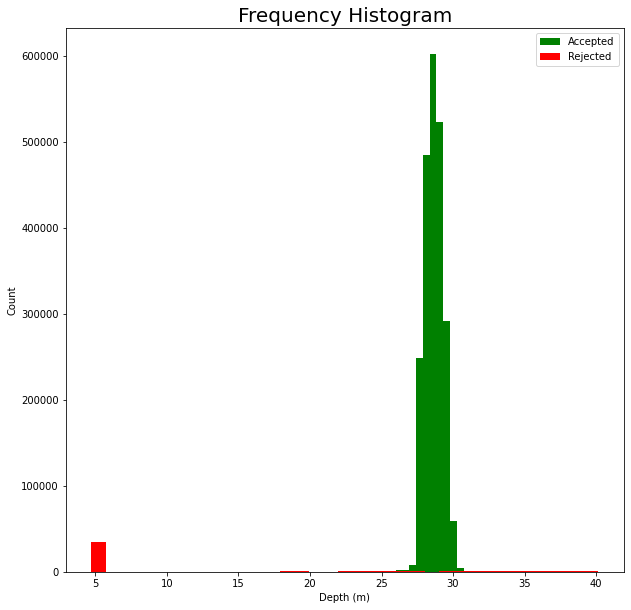

In [3]:
# Full dataset stats:
print("\nFull Dataset, X Stats: ")
print_stats(data["x"])
print("\nFull Dataset, Y Stats: ")
print_stats(data["y"])
print("\nFull Dataset, Depth Stats: ")
print_stats(data["depth"])

data_clean = data[data["flag"] != 1]
data_flag = data[data["flag"] == 1]

# Cleaned dataset stats:
print("\nCleaned Dataset, X Stats: ")
print_stats(data_clean["x"])
print("\nCleaned Dataset, Y Stats: ")
print_stats(data_clean["y"])
print("\nCleaned Dataset, Depth Stats: ")
print_stats(data_clean["depth"])

print("\nFlagged Stats (0 = Accepted; 1 = Rejected): ")
flagged_data_counts = data["flag"].value_counts()
flagged_data_percent = data["flag"].value_counts(normalize=True)
for i in range(len(flagged_data_counts)):
    print("Value: %d; Count: %d; Percent: %f"%(i, flagged_data_counts[i], flagged_data_percent[i] * 100))
print("\nAccepted Depth Stats: ")
print_stats(data_clean["depth"])
print("\nRejected Depth Stats: ")
print_stats(data_flag["depth"])

# Histogram for cleaned depth data:
fig, ax = plt.subplots(figsize=(10,10))
plt.hist(data_clean["depth"], bins=(int(np.max(data["depth"]) - np.min(data["depth"]))), color='g', label="Accepted")
plt.hist(data_flag["depth"], bins=(int(np.max(data["depth"]) - np.min(data["depth"]))), color='r', label="Rejected")
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Depth (m)")
ax.set_ylabel("Count")
ax.set_title("Frequency Histogram", fontsize=20)
plt.legend();

<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## IHO Survey Standards
#### Maximum Total Vertical Uncertainty (TVU): sqrt(a^2 + (b * d)^2)
##### --Special Order: "Areas where underkeel clearance is critical." a = 0.25 m; b = 0.0075
##### --Order 1a: "Areas where underkeel clearance is considered not to be critical but features of concern to surface shipping may exist." a = 0.5 m; b = 0.013
##### --Order 1b: "Areas where underkeel clearance is not considered to be an issue for the type of surface shipping expected to transit the area." a = 0.5 m; b = 0.013
##### --Order 2: "Areas where a general description of the sea floor is considered adequate." a = 1.0 m; b = 0.023
------------------------------------------------------------

In [7]:
# Use median depth of cleaned data for nominal depth value:
nominal_depth = np.percentile(data_clean["depth"], 50)
print("Median depth of cleaned data: %f"%(nominal_depth))
# Let's assume loosest survey standards (though, in reality, this would be unlikely in this water depth).
a_order2 = 1.0
b_order2 = 0.023
tvu_order2 = math.sqrt((a_order2 ** 2) + ((b_order2 * nominal_depth) ** 2))
print("IHO Survey Standards, Order 2 Survey")
print("Maximum Allowable Vertical Uncertainty: %f"%(tvu_order2))


Median depth of cleaned data: 28.670000
IHO Survey Standards, Order 2 Survey
Maximum Allowable Vertical Uncertainty: 1.197840


<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Plot original (raw and cleaned) data:
------------------------------------------------------------

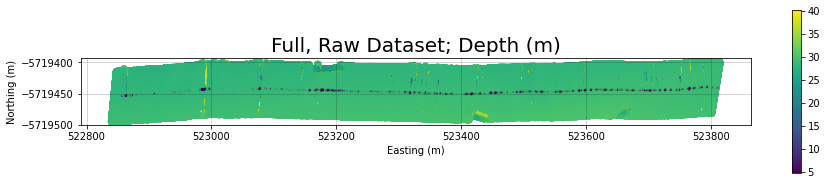

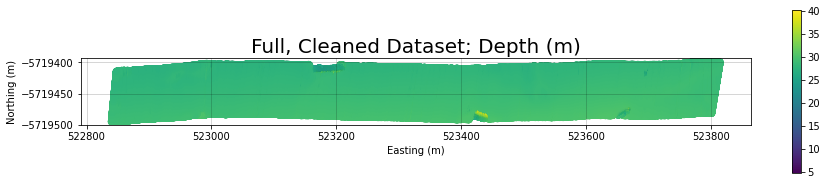

In [11]:
# Recall: Longitude is converted to x coordinate (easting); latitude is converted to y coordinate (northing)

# Full, raw dataset:
fig, ax = plt.subplots(figsize=(15,15))
im1 = ax.scatter(data["x"], data["y"], c=data["depth"], vmin=data["depth"].min(), vmax=data["depth"].max())
# set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
ax.set_aspect(1)
# Disable scientific notation of axes ticks:
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Full, Raw Dataset; Depth (m)", fontsize=20)
ax.grid(c='k', alpha=0.2)
cb1 = fig.colorbar(im1, shrink=0.2);

# Full, cleaned dataset:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.scatter(data_clean["x"], data_clean["y"], c=data_clean["depth"], vmin=data["depth"].min(), vmax=data["depth"].max())
# set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
ax.set_aspect(1)
# Disable scientific notation of axes ticks:
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Full, Cleaned Dataset; Depth (m)", fontsize=20)
ax.grid(c='k', alpha=0.2)
cb = fig.colorbar(im, shrink=0.2)


<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Subsample (raw and cleaned) data:
##### --Note tiny subsample rate (0.001), which is not ideal. This will eliminate the vast majority of multibeam data points, many of which are valid (~98% for this line). Memory errors encountered with larger sample rate...
------------------------------------------------------------

In [12]:
#subsample = 0.025 # This does not work for interpolation algorithm--requires too much memory...
subsample = 0.001 # One data point for every 1000 data points! Ah!
subsample_size = int(len(data.index) * subsample)

# Subset x, y, z from full dataset:
x_sub_raw = data["x"].sample(subsample_size)
y_sub_raw = data["y"].sample(subsample_size)
z_sub_raw = data["depth"].sample(subsample_size)

# Subset x, y, z from cleaned dataset:
x_sub_clean = data_clean["x"].sample(subsample_size)
y_sub_clean = data_clean["y"].sample(subsample_size)
z_sub_clean = data_clean["depth"].sample(subsample_size)

# Subset from full, raw dataset stats:
print("\nSubset From Subsampled, Raw Dataset, X Stats: ")
print_stats(x_sub_raw)
print("\nSubset From Subsampled, Raw Dataset, Y Stats: ")
print_stats(y_sub_raw)
print("\nSubset From Subsampled, Raw Dataset, Depth Stats: ")
print_stats(z_sub_raw)

# Subset from full dataset stats:
print("\nSubset From Subsampled, Cleaned Dataset, X Stats: ")
print_stats(x_sub_clean)
print("\nSubset From Subsampled, Cleaned Dataset, Y Stats: ")
print_stats(y_sub_clean)
print("\nSubset From Subsampled, Cleaned Dataset, Depth Stats: ")
print_stats(z_sub_clean)


Subset From Subsampled, Raw Dataset, X Stats: 
Min: 522844.312500
Max: 523810.000000
Range: 965.687500
5th percentile: 522890.434375
10th percentile: 522930.881250
25th percentile: 523068.781250
50th percentile: 523310.281250
75th percentile: 523556.015625
90th percentile: 523705.325000
95th percentile: 523755.981250

Subset From Subsampled, Raw Dataset, Y Stats: 
Min: -5719495.000000
Max: -5719398.500000
Range: 96.500000
5th percentile: -5719482.000000
10th percentile: -5719478.000000
25th percentile: -5719465.250000
50th percentile: -5719445.000000
75th percentile: -5719425.000000
90th percentile: -5719413.000000
95th percentile: -5719409.000000

Subset From Subsampled, Raw Dataset, Depth Stats: 
Min: 4.860000
Max: 37.849998
Range: 32.989998
5th percentile: 27.660000
10th percentile: 27.820000
25th percentile: 28.180000
50th percentile: 28.660000
75th percentile: 29.100000
90th percentile: 29.450001
95th percentile: 29.650000

Subset From Subsampled, Cleaned Dataset, X Stats: 
Min: 

<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Plot subsampled (raw and cleaned) data:
------------------------------------------------------------

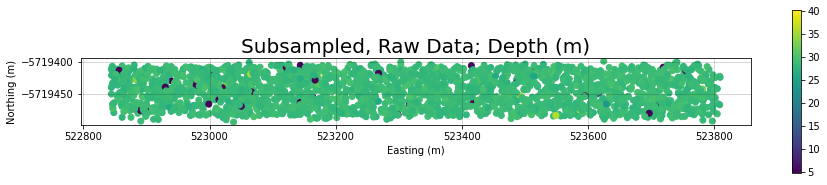

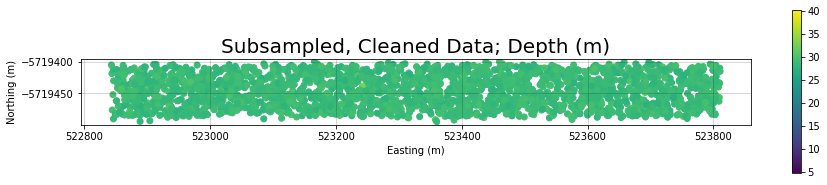

In [13]:
# Plot subsampled, raw data:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.scatter(x_sub_raw, y_sub_raw, c=z_sub_raw, vmin=data["depth"].min(), vmax=data["depth"].max())
# set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
ax.set_aspect(1)
# Disable scientific notation of axes ticks:
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Subsampled, Raw Data; Depth (m)", fontsize=20)
ax.grid(c='k', alpha=0.2)
cb = fig.colorbar(im, shrink=0.2)

# Plot subsampled, cleaned data:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.scatter(x_sub_clean, y_sub_clean, c=z_sub_clean, vmin=data["depth"].min(), vmax=data["depth"].max())
# set_aspect(1) is synonomous with 'equal'; i.e. same scaling for x and y
ax.set_aspect(1)
# Disable scientific notation of axes ticks:
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Subsampled, Cleaned Data; Depth (m)", fontsize=20)
ax.grid(c='k', alpha=0.2)
cb = fig.colorbar(im, shrink=0.2)


<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Interpolate subsampled (raw and cleaned) data: Radial Basis Function (RBF), with default parameters.
##### --Default Radial Basis Function (RBF) is 'multiquadric': sqrt((r/self.epsilon)**2 + 1)
------------------------------------------------------------

In [14]:
# Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb

# Make a regular grid, which represents points we want to predict:
# (1 indicates a bin every 1 m)
grid_x, grid_y = np.mgrid[(data["x"].min() - 10):(data["x"].max() + 10):1,
                 (data["y"].min() - 10):(data["y"].max() + 10):1]

extent = [(data["x"].min() - 10), (data["x"].max() + 10),
          (data["y"].min() - 10), (data["y"].max() + 10)]

vmin = data["depth"].min()
vmax = data["depth"].max()

##### Interpolate (RBF=Multiquadric, Smooth= 0.0)

Interpolated (RBF=multiquadric, Smooth=0.00), Subsampled, Raw Data:

Min: -622.025952
Max: 749.568817
Range: 1371.594768
5th percentile: 19.384506
10th percentile: 23.868707
25th percentile: 27.075926
50th percentile: 28.541719
75th percentile: 29.788953
90th percentile: 32.446998
95th percentile: 35.899733

ERROR: Interpolated (RBF=multiquadric, Smooth 0.00) Raw Data at Raw Data Points
Mean: 0.000000
Standard Deviation: 0.000000

ERROR: Interpolated (RBF=multiquadric, Smooth 0.00) Raw Data at Clean Data Points
Mean: -0.720001
Standard Deviation: 23.152429


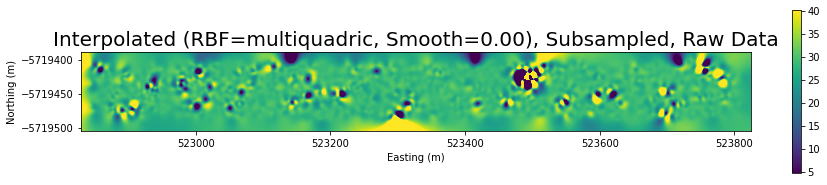

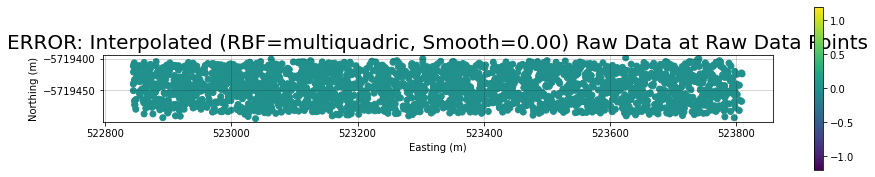

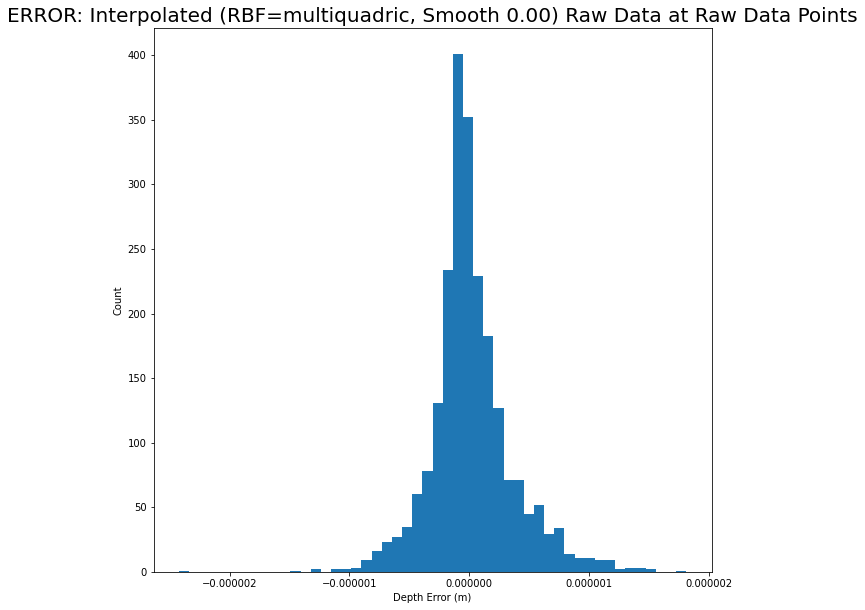

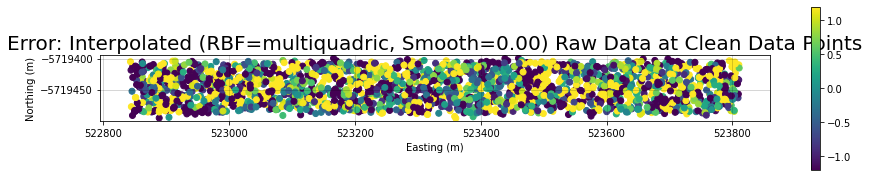

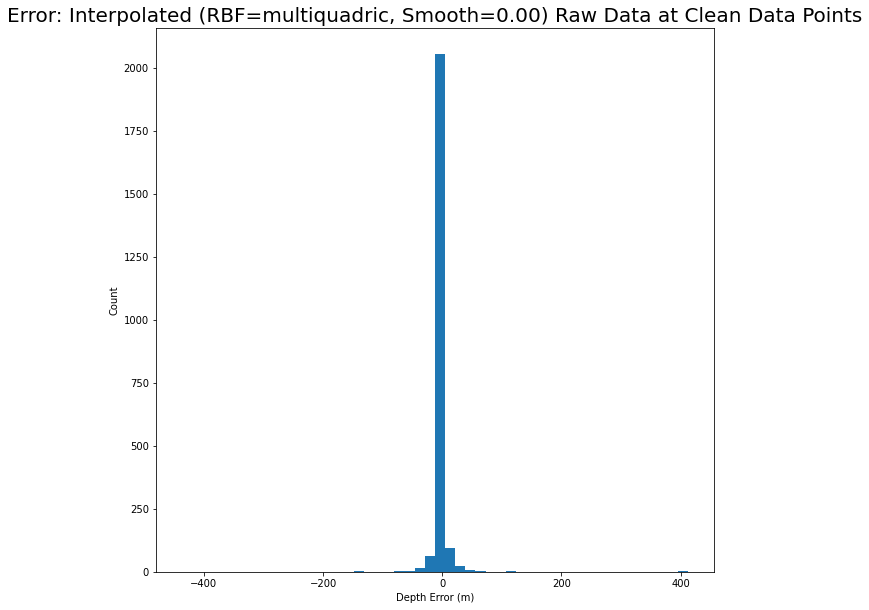

In [61]:
# Interpolate (RBF=Multiquadric, Smooth=0.0) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, smooth=0.0)

##### Interpolate (RBF=Multiquadric, Smooth= 0.1)

Interpolated (RBF=multiquadric, Smooth=0.10), Subsampled, Raw Data:

Min: 4.155377
Max: 35.191684
Range: 31.036307
5th percentile: 24.709390
10th percentile: 27.307491
25th percentile: 28.186204
50th percentile: 28.618534
75th percentile: 28.996227
90th percentile: 29.382371
95th percentile: 29.692380

ERROR: Interpolated (RBF=multiquadric, Smooth 0.10) Raw Data at Raw Data Points
Mean: 0.000014
Standard Deviation: 1.979464

ERROR: Interpolated (RBF=multiquadric, Smooth 0.10) Raw Data at Clean Data Points
Mean: -0.420023
Standard Deviation: 2.059911


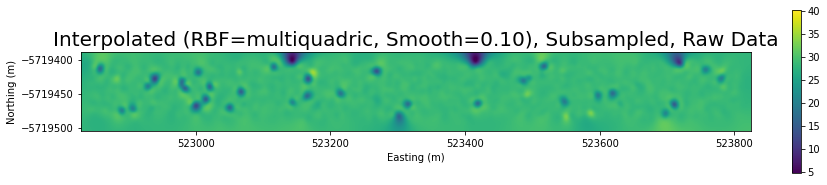

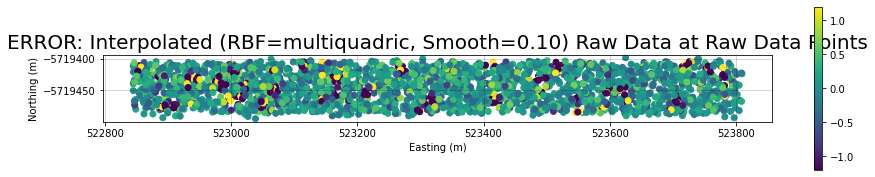

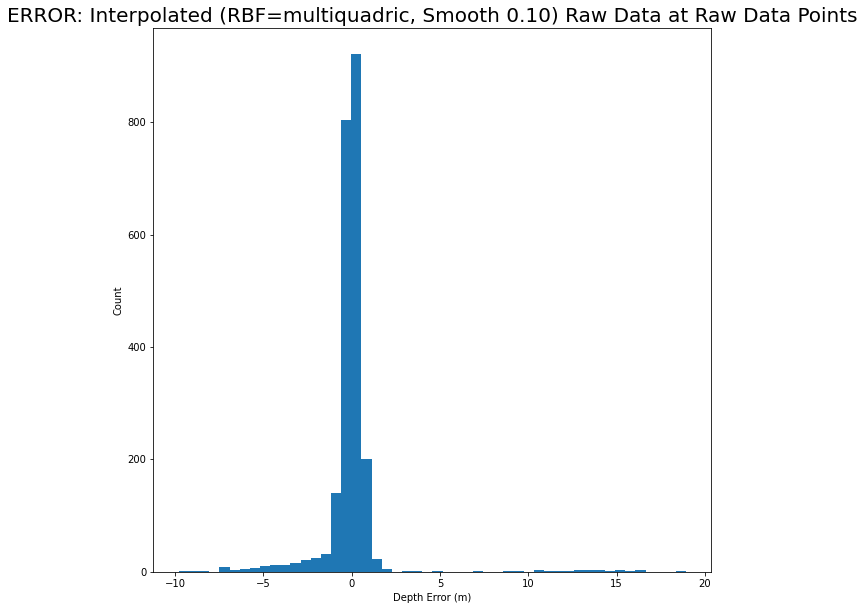

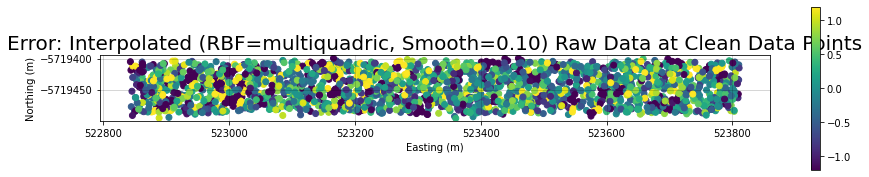

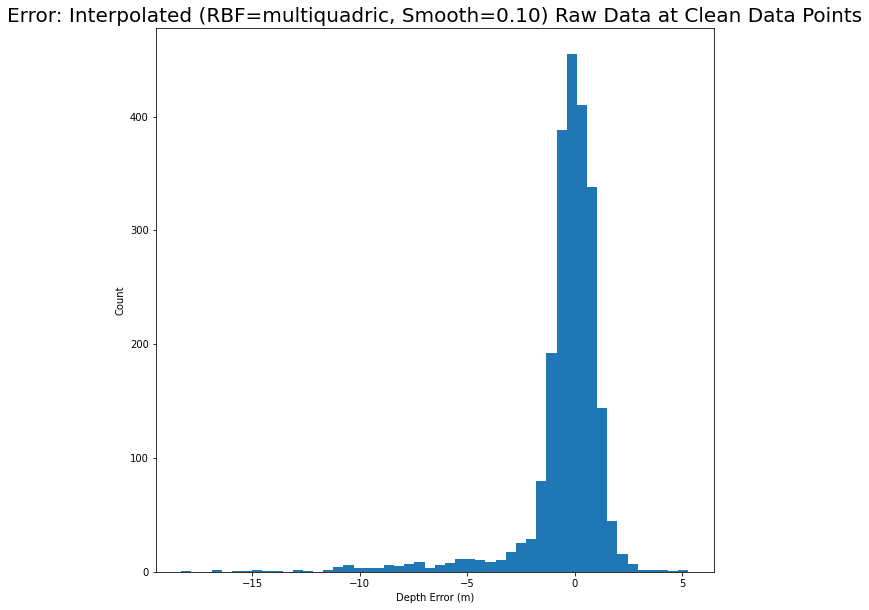

In [62]:
# Interpolate (RBF=Multiquadric, Smooth=0.1) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, smooth=0.1)

##### Interpolate (RBF=Multiquadric, Smooth= 0.2)

Interpolated (RBF=multiquadric, Smooth=0.20), Subsampled, Raw Data:

Min: 6.907706
Max: 33.822255
Range: 26.914549
5th percentile: 24.889395
10th percentile: 27.447483
25th percentile: 28.251940
50th percentile: 28.621702
75th percentile: 28.946952
90th percentile: 29.274447
95th percentile: 29.498717

ERROR: Interpolated (RBF=multiquadric, Smooth 0.20) Raw Data at Raw Data Points
Mean: 0.000029
Standard Deviation: 2.177077

ERROR: Interpolated (RBF=multiquadric, Smooth 0.20) Raw Data at Clean Data Points
Mean: -0.410877
Standard Deviation: 1.795640


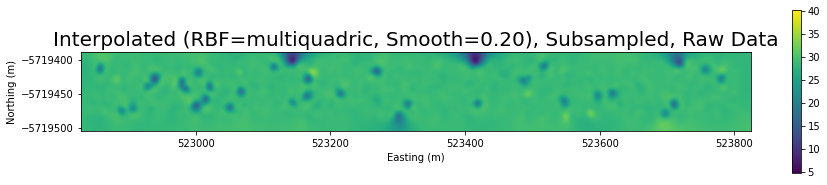

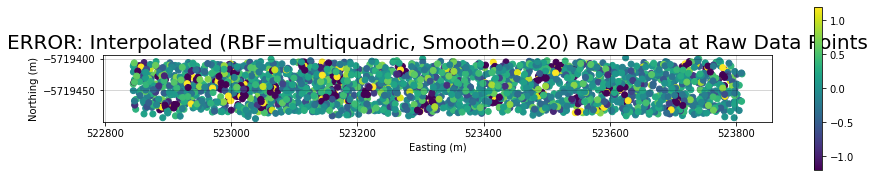

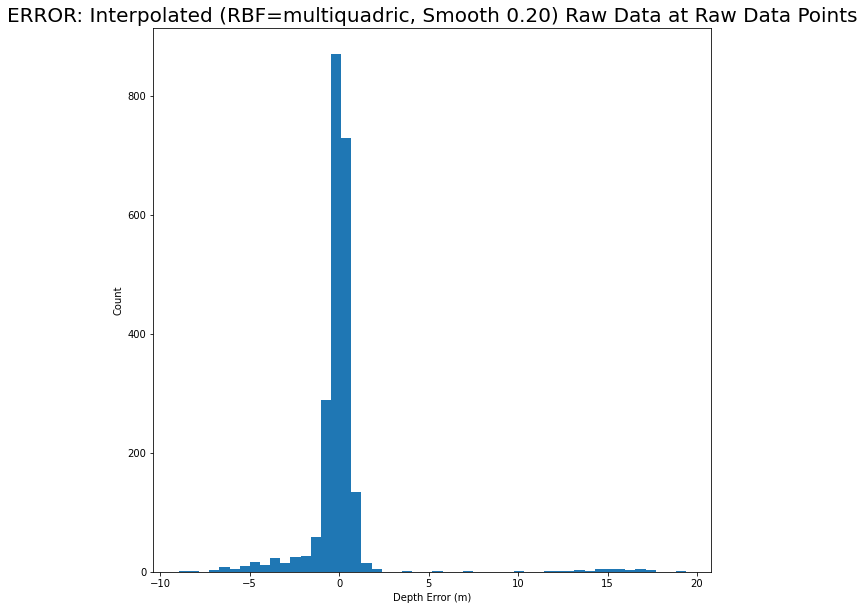

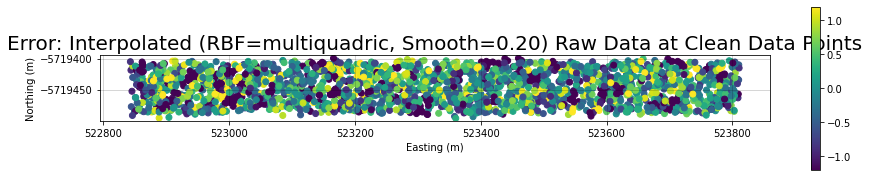

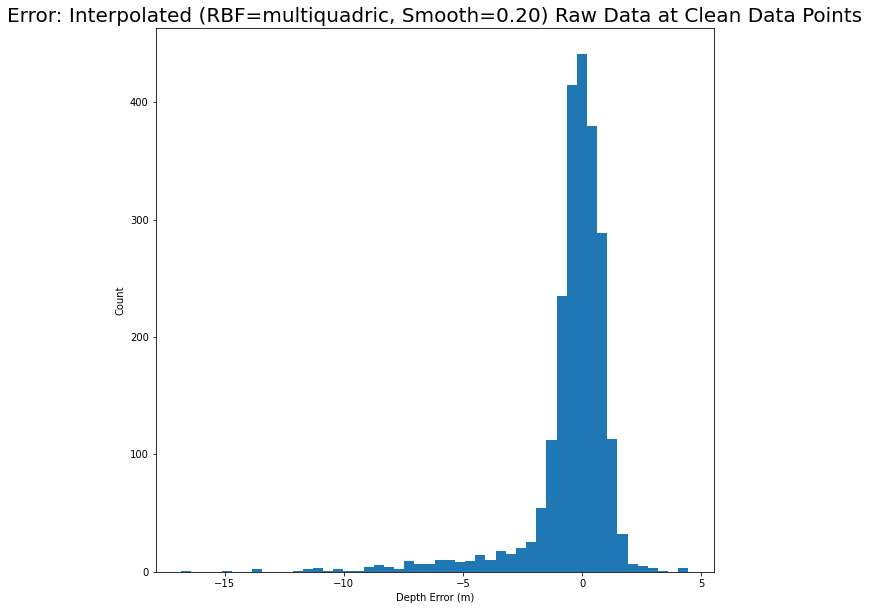

In [63]:
# Interpolate (RBF=Multiquadric, Smooth=0.2) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, smooth=0.2)

##### Interpolate (RBF=Multiquadric, Smooth= 0.3)

Interpolated (RBF=multiquadric, Smooth=0.30), Subsampled, Raw Data:

Min: 8.847836
Max: 33.026955
Range: 24.179120
5th percentile: 25.065363
10th percentile: 27.430598
25th percentile: 28.294051
50th percentile: 28.623445
75th percentile: 28.922465
90th percentile: 29.222835
95th percentile: 29.425107

ERROR: Interpolated (RBF=multiquadric, Smooth 0.30) Raw Data at Raw Data Points
Mean: 0.000045
Standard Deviation: 2.282754

ERROR: Interpolated (RBF=multiquadric, Smooth 0.30) Raw Data at Clean Data Points
Mean: -0.403393
Standard Deviation: 1.655223


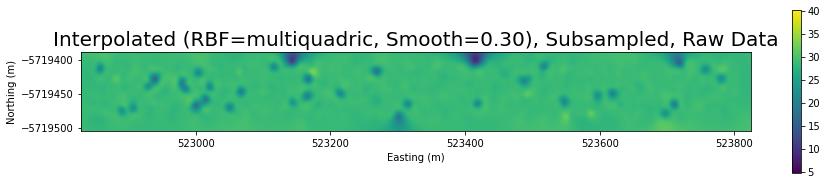

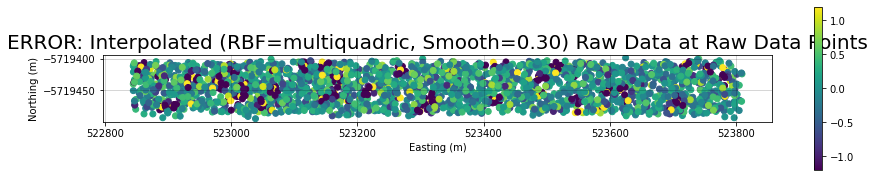

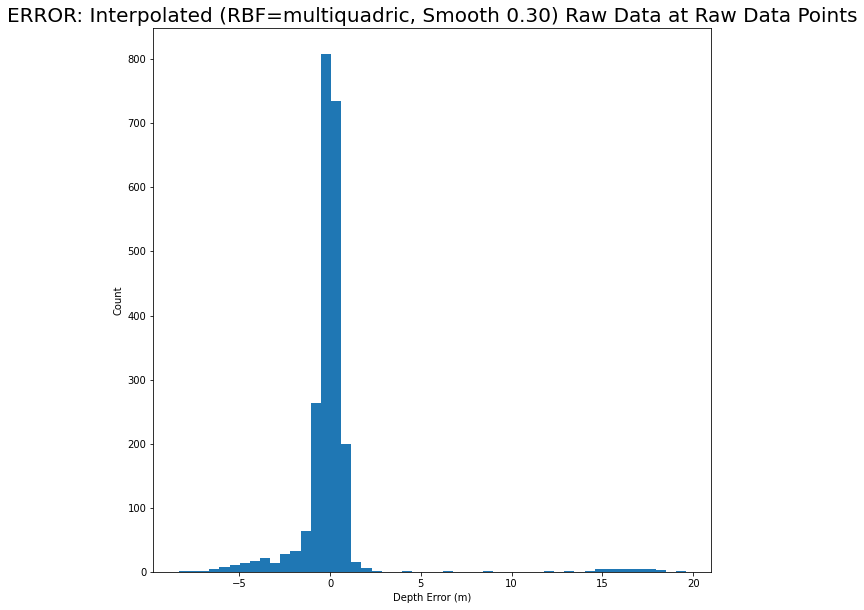

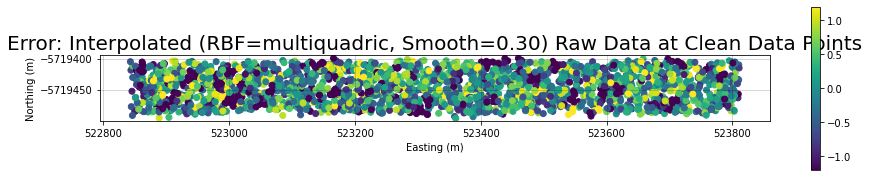

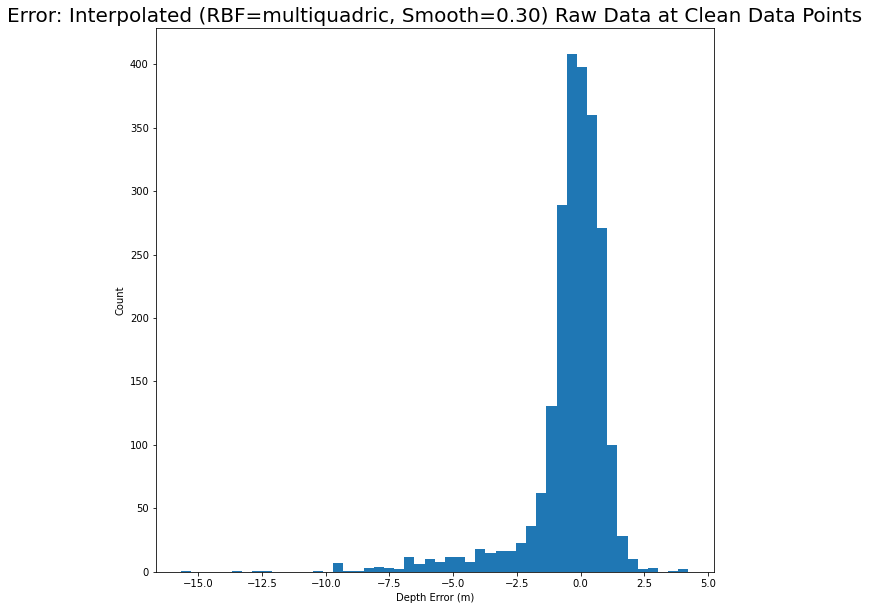

In [64]:
# Interpolate (RBF=Multiquadric, Smooth=0.3) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, smooth=0.3)

##### Interpolate (RBF=Multiquadric, Smooth= 0.4)

Interpolated (RBF=multiquadric, Smooth=0.40), Subsampled, Raw Data:

Min: 10.347276
Max: 32.455874
Range: 22.108598
5th percentile: 25.209860
10th percentile: 27.379847
25th percentile: 28.317954
50th percentile: 28.629678
75th percentile: 28.908241
90th percentile: 29.186247
95th percentile: 29.390654

ERROR: Interpolated (RBF=multiquadric, Smooth 0.40) Raw Data at Raw Data Points
Mean: 0.000061
Standard Deviation: 2.352975

ERROR: Interpolated (RBF=multiquadric, Smooth 0.40) Raw Data at Clean Data Points
Mean: -0.397525
Standard Deviation: 1.560689


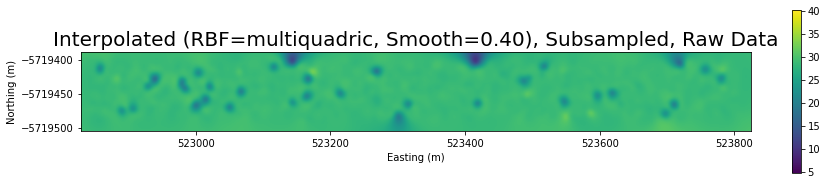

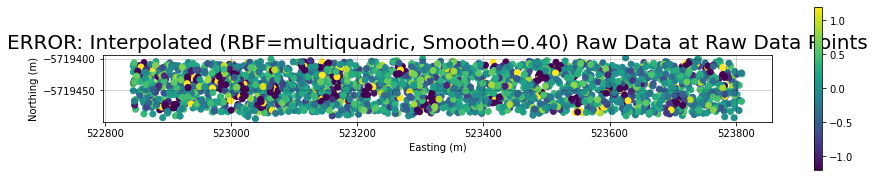

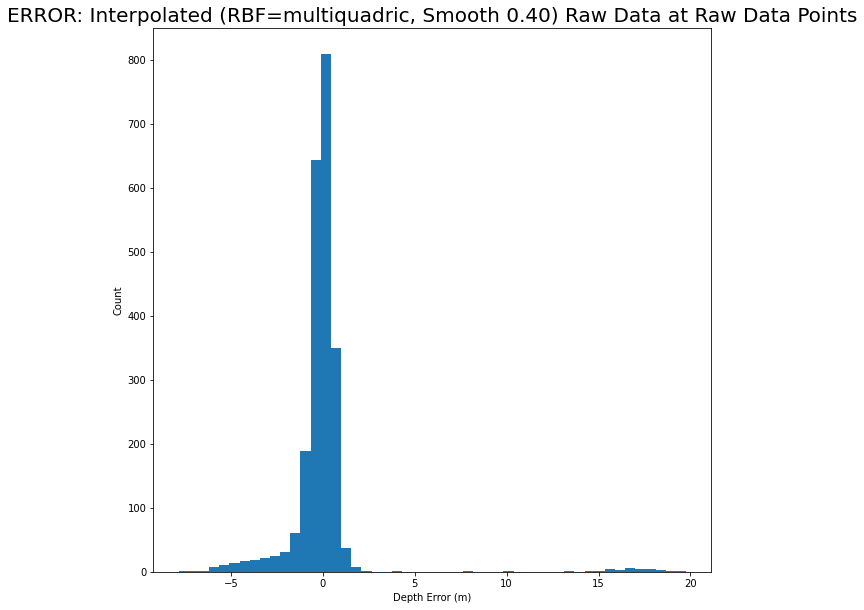

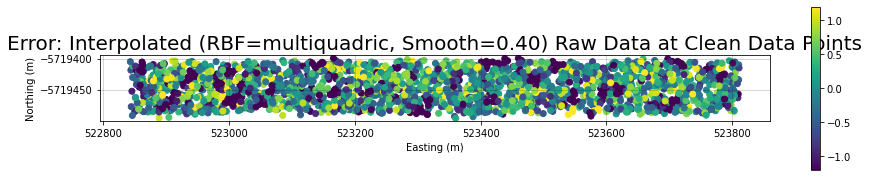

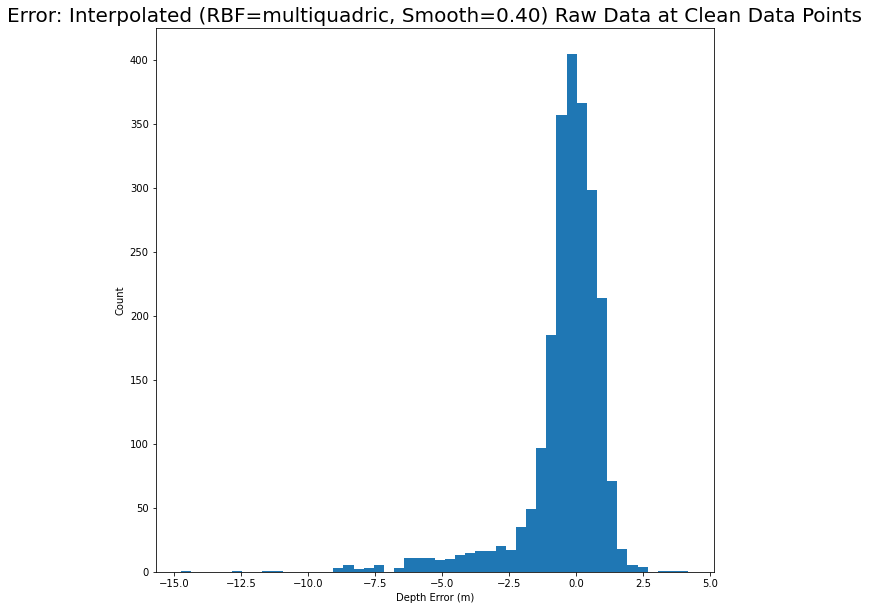

In [65]:
# Interpolate (RBF=Multiquadric, Smooth=0.4) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, smooth=0.4)

##### Interpolate (RBF=Multiquadric, Smooth= 0.5)

Interpolated (RBF=multiquadric, Smooth=0.50), Subsampled, Raw Data:

Min: 11.562603
Max: 32.035655
Range: 20.473052
5th percentile: 25.333745
10th percentile: 27.335065
25th percentile: 28.339066
50th percentile: 28.635645
75th percentile: 28.898346
90th percentile: 29.161925
95th percentile: 29.356083

ERROR: Interpolated (RBF=multiquadric, Smooth 0.50) Raw Data at Raw Data Points
Mean: 0.000077
Standard Deviation: 2.404727

ERROR: Interpolated (RBF=multiquadric, Smooth 0.50) Raw Data at Clean Data Points
Mean: -0.392846
Standard Deviation: 1.490021


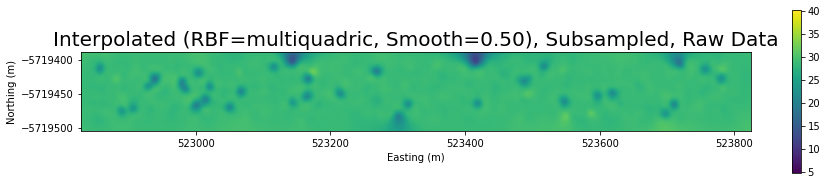

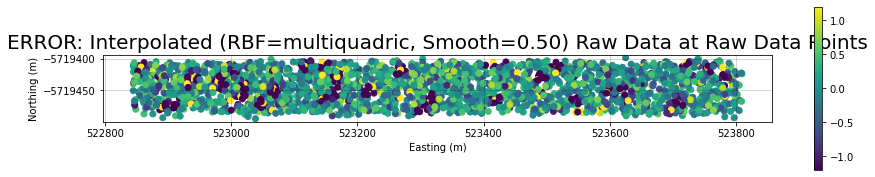

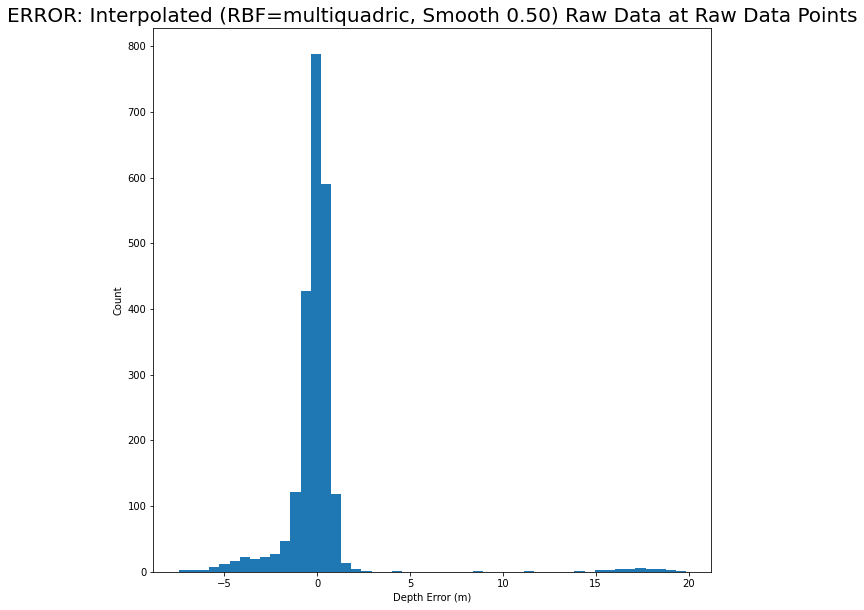

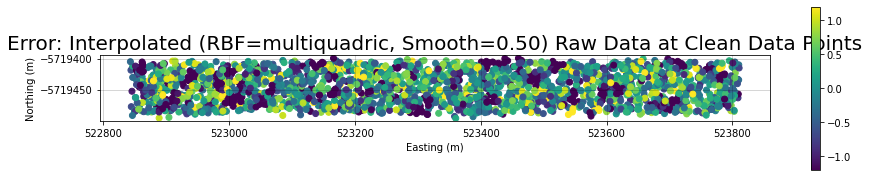

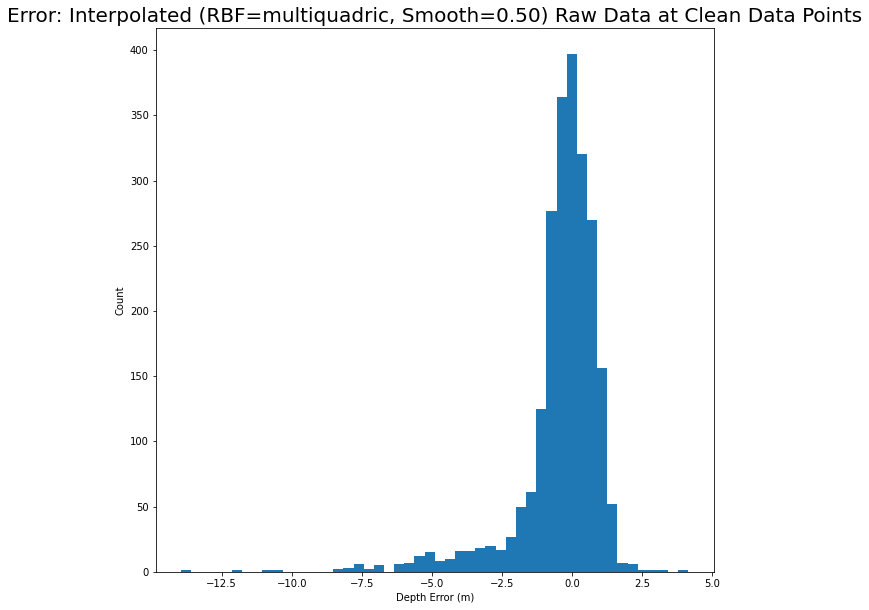

In [66]:
# Interpolate (RBF=Multiquadric, Smooth=0.5) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, smooth=0.5)


<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Interpolate subsampled (raw and cleaned) data: Radial Basis Function (RBF), with optional parameters.
##### --Radial Basis Function (RBF) is 'gaussian': exp(-(r/self.epsilon)**2)
------------------------------------------------------------

##### Interpolate (RBF=Gaussian, Smooth= 0.0)

Interpolated (RBF=gaussian, Smooth=0.00), Subsampled, Raw Data:

Min: -1688.038345
Max: 1228.266907
Range: 2916.305252
5th percentile: 0.003789
10th percentile: 0.085681
25th percentile: 6.149415
50th percentile: 24.794668
75th percentile: 28.587725
90th percentile: 30.659741
95th percentile: 33.808761

ERROR: Interpolated (RBF=gaussian, Smooth 0.00) Raw Data at Raw Data Points
Mean: 0.000000
Standard Deviation: 0.000000

ERROR: Interpolated (RBF=gaussian, Smooth 0.00) Raw Data at Clean Data Points
Mean: -3.630087
Standard Deviation: 46.850150


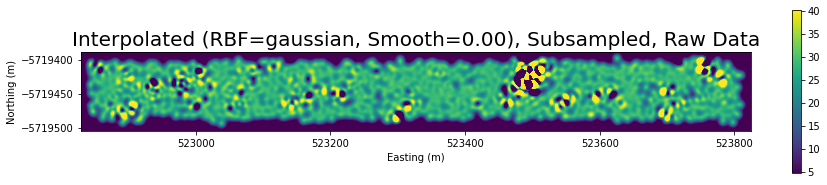

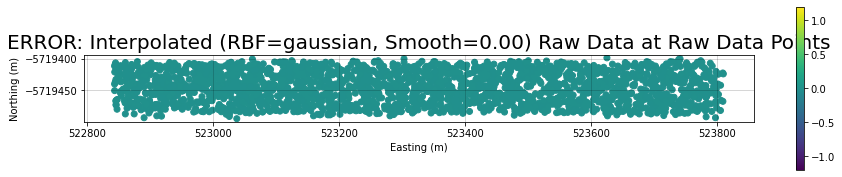

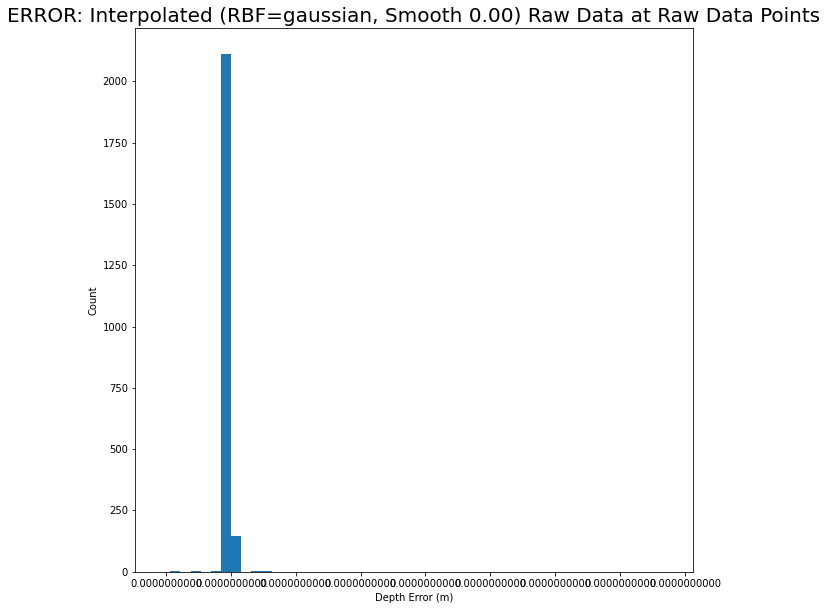

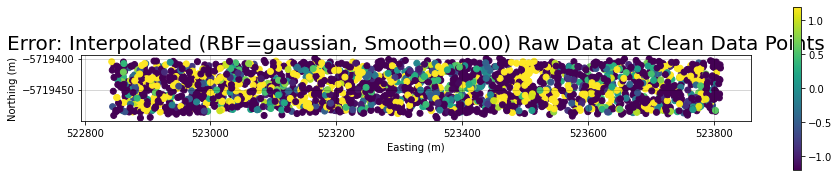

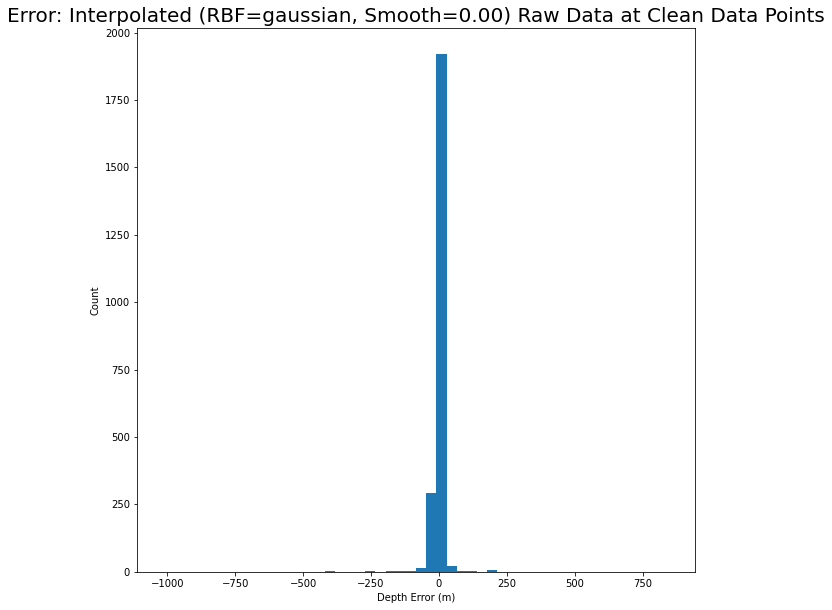

In [67]:
# Interpolate (RBF=Gaussian, Smooth=0.0) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, function='gaussian', smooth=0.0)

##### Interpolate (RBF=Gaussian, Smooth= 0.1)

Interpolated (RBF=gaussian, Smooth=0.10), Subsampled, Raw Data:

Min: -1349.537365
Max: 1214.608345
Range: 2564.145710
5th percentile: -10.223256
10th percentile: -0.048827
25th percentile: 1.662049
50th percentile: 22.123447
75th percentile: 31.031753
90th percentile: 40.955570
95th percentile: 55.071540

ERROR: Interpolated (RBF=gaussian, Smooth 0.10) Raw Data at Raw Data Points
Mean: 0.814759
Standard Deviation: 43.397890

ERROR: Interpolated (RBF=gaussian, Smooth 0.10) Raw Data at Clean Data Points
Mean: 2.456862
Standard Deviation: 80.050805


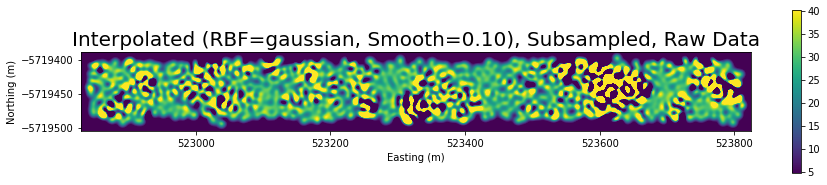

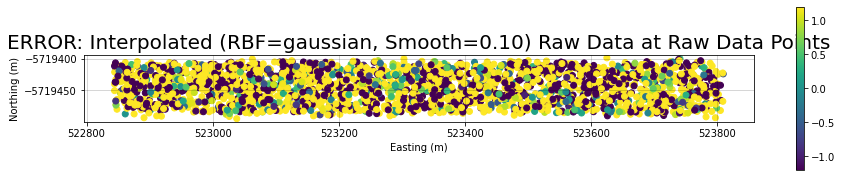

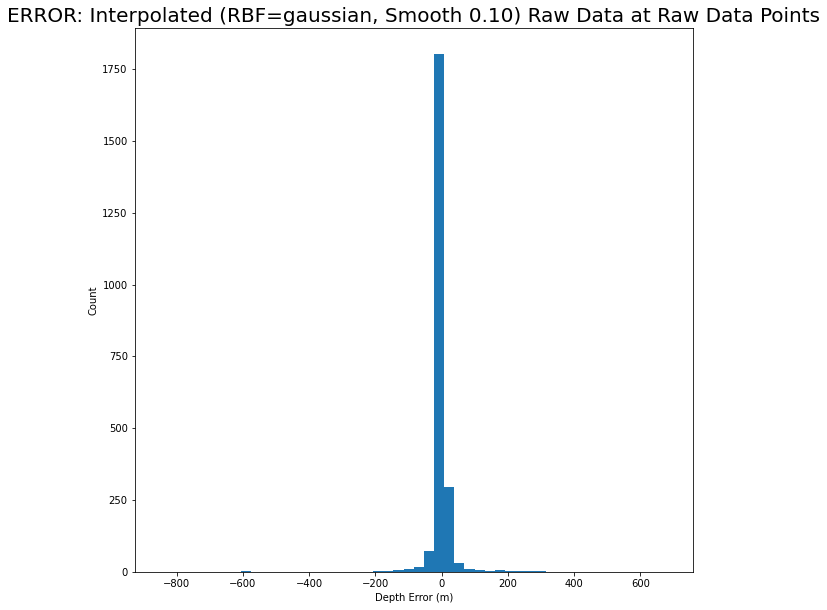

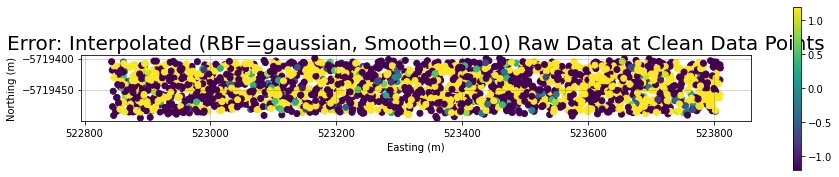

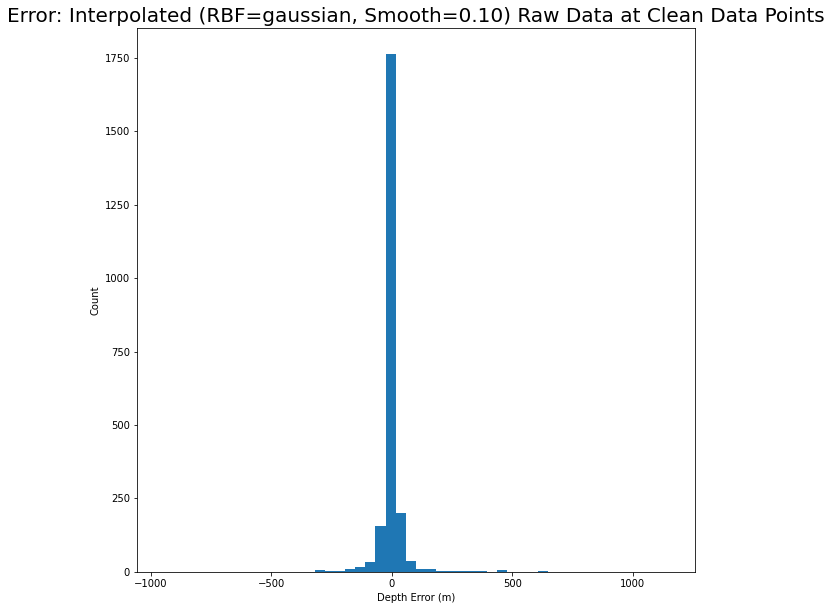

In [68]:
# Interpolate (RBF=Gaussian, Smooth=0.1) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, function='gaussian', smooth=0.1)

##### Interpolate (RBF=Gaussian, Smooth= 0.2)

Interpolated (RBF=gaussian, Smooth=0.20), Subsampled, Raw Data:

Min: -1921.169914
Max: 1267.411022
Range: 3188.580936
5th percentile: -54.330798
10th percentile: -15.081466
25th percentile: 0.072113
50th percentile: 18.106671
75th percentile: 35.211145
90th percentile: 59.417999
95th percentile: 89.311535

ERROR: Interpolated (RBF=gaussian, Smooth 0.20) Raw Data at Raw Data Points
Mean: 1.281941
Standard Deviation: 70.983141

ERROR: Interpolated (RBF=gaussian, Smooth 0.20) Raw Data at Clean Data Points
Mean: -5.495993
Standard Deviation: 101.784576


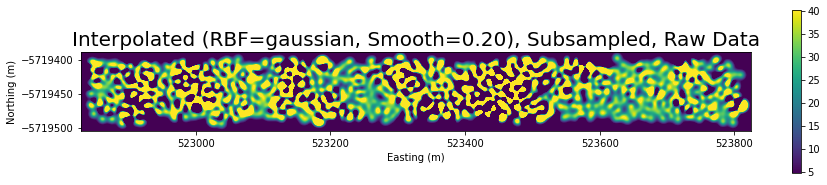

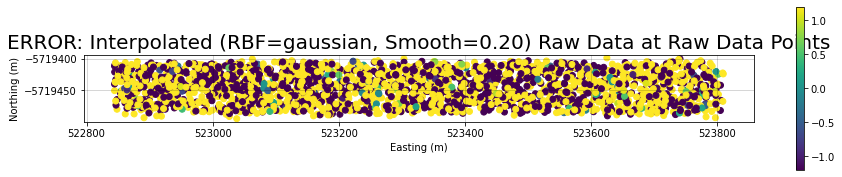

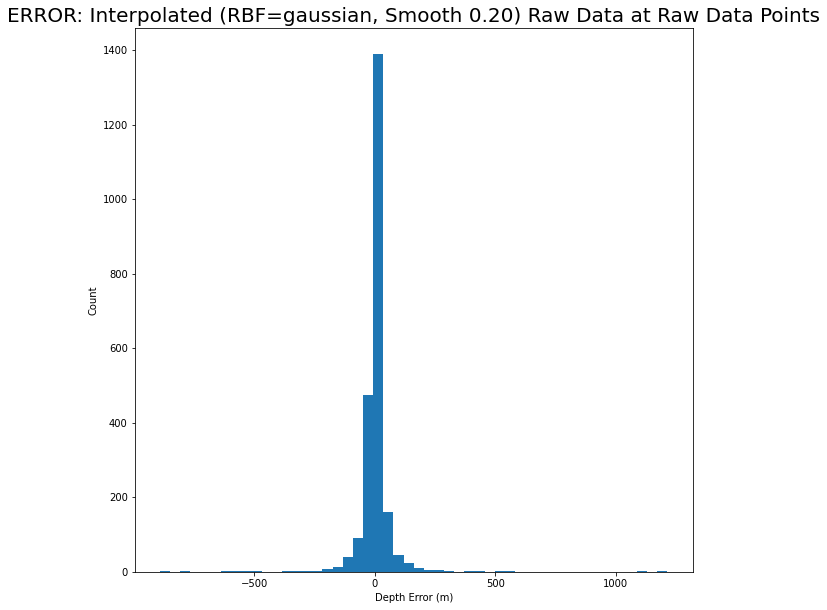

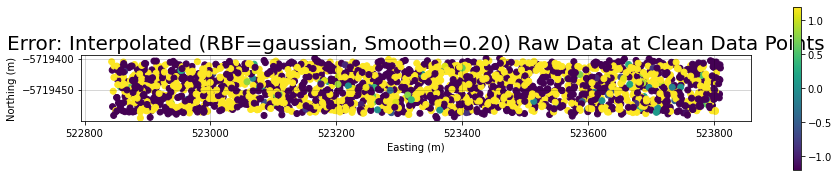

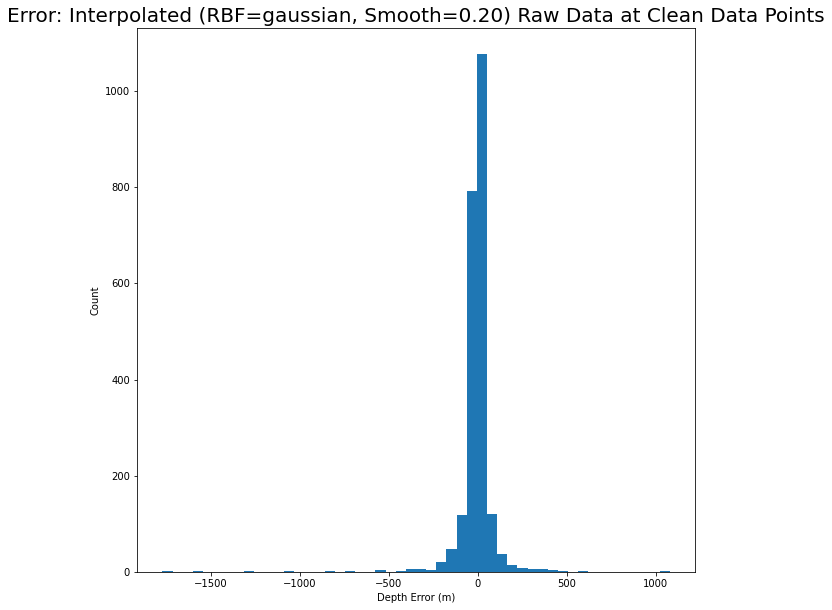

In [69]:
# Interpolate (RBF=Gaussian, Smooth=0.2) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, function='gaussian', smooth=0.2)

##### Interpolate (RBF=Gaussian, Smooth= 0.3)

Interpolated (RBF=gaussian, Smooth=0.30), Subsampled, Raw Data:

Min: -1828.571723
Max: 1801.250193
Range: 3629.821916
5th percentile: -96.512341
10th percentile: -37.255024
25th percentile: 0.000024
50th percentile: 15.004909
75th percentile: 39.894644
90th percentile: 81.462736
95th percentile: 138.817997

ERROR: Interpolated (RBF=gaussian, Smooth 0.30) Raw Data at Raw Data Points
Mean: 2.128460
Standard Deviation: 110.046365

ERROR: Interpolated (RBF=gaussian, Smooth 0.30) Raw Data at Clean Data Points
Mean: -4.376229
Standard Deviation: 129.727241


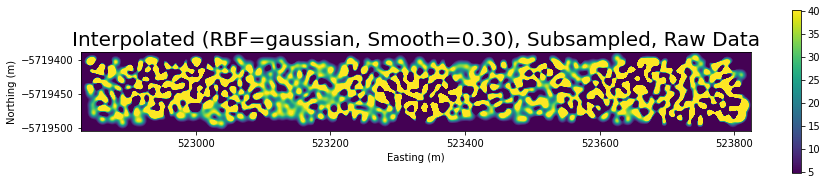

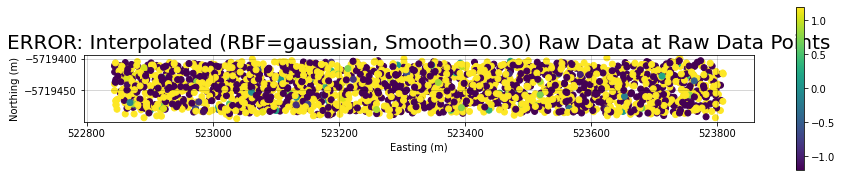

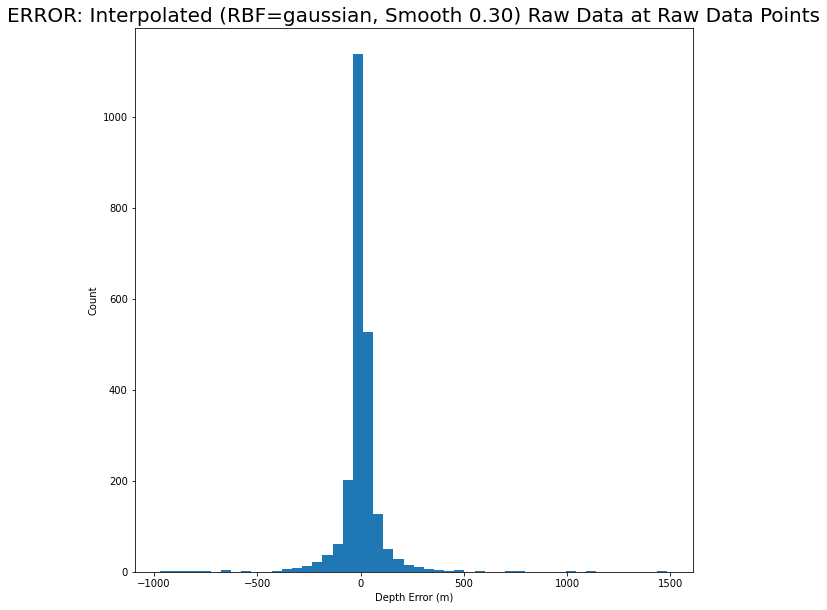

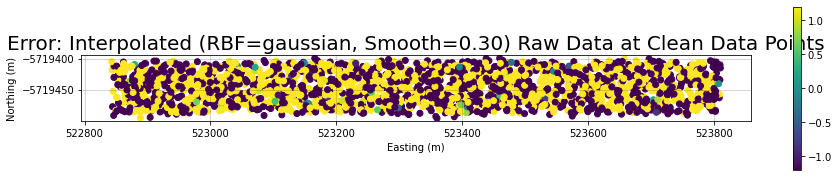

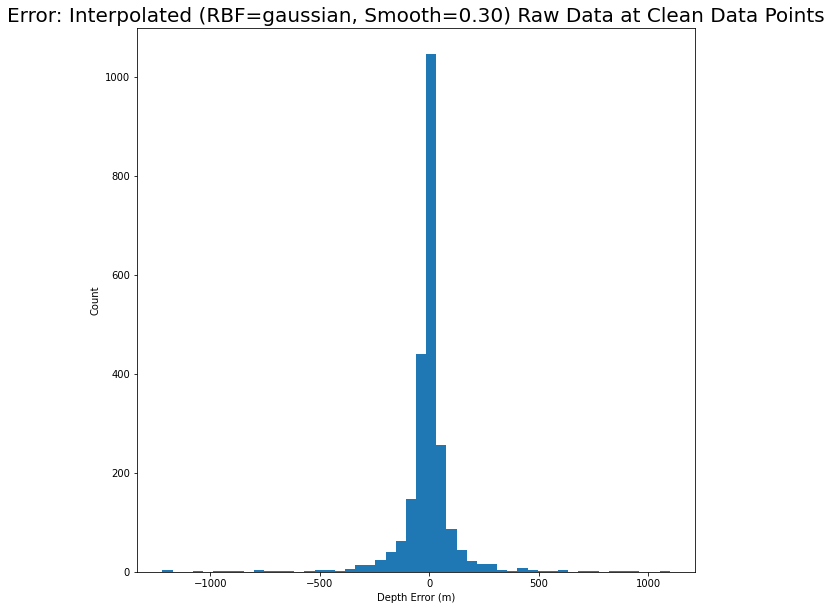

In [70]:
# Interpolate (RBF=Gaussian, Smooth=0.3) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, function='gaussian', smooth=0.3)

##### Interpolate (RBF=Gaussian, Smooth= 0.4)

Interpolated (RBF=gaussian, Smooth=0.40), Subsampled, Raw Data:

Min: -1716.384888
Max: 1817.173238
Range: 3533.558126
5th percentile: -51.600669
10th percentile: -14.700656
25th percentile: 0.102939
50th percentile: 18.414612
75th percentile: 39.532169
90th percentile: 68.657156
95th percentile: 105.431315

ERROR: Interpolated (RBF=gaussian, Smooth 0.40) Raw Data at Raw Data Points
Mean: 3.369488
Standard Deviation: 80.670108

ERROR: Interpolated (RBF=gaussian, Smooth 0.40) Raw Data at Clean Data Points
Mean: -2.756978
Standard Deviation: 101.656088


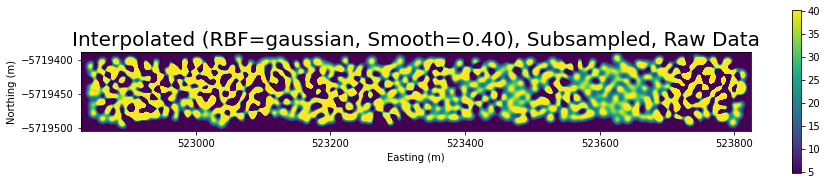

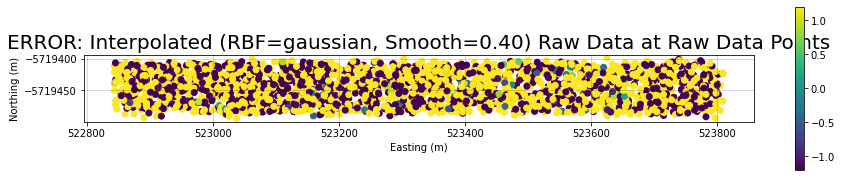

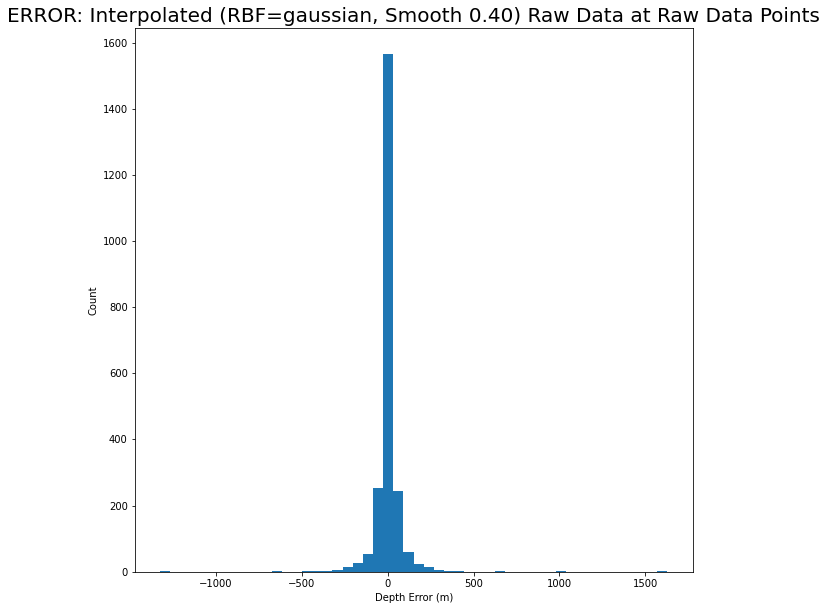

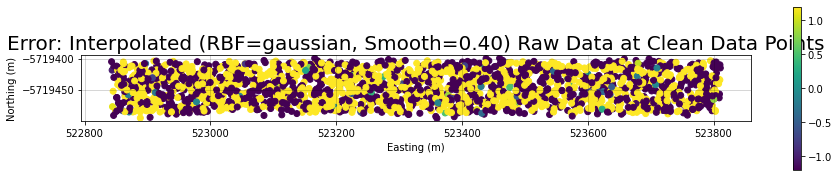

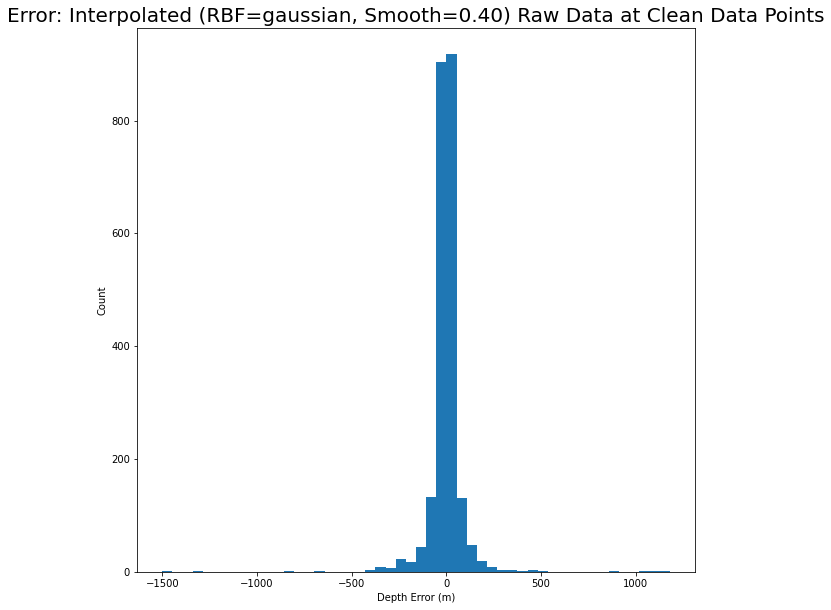

In [71]:
# Interpolate (RBF=Gaussian, Smooth=0.4) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, function='gaussian', smooth=0.4)

##### Interpolate (RBF=Gaussian, Smooth= 0.5)

Interpolated (RBF=gaussian, Smooth=0.50), Subsampled, Raw Data:

Min: -1933.193429
Max: 1846.099817
Range: 3779.293246
5th percentile: -110.933507
10th percentile: -50.062643
25th percentile: -0.387055
50th percentile: 14.915561
75th percentile: 52.217438
90th percentile: 118.162304
95th percentile: 199.325541

ERROR: Interpolated (RBF=gaussian, Smooth 0.50) Raw Data at Raw Data Points
Mean: 5.638506
Standard Deviation: 147.686682

ERROR: Interpolated (RBF=gaussian, Smooth 0.50) Raw Data at Clean Data Points
Mean: 9.522044
Standard Deviation: 150.503397


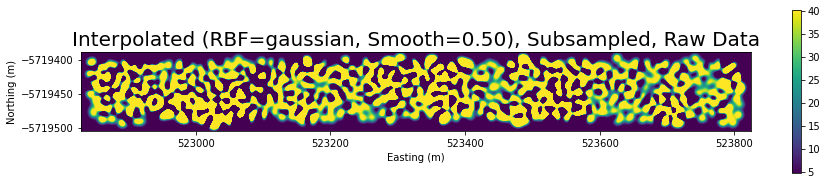

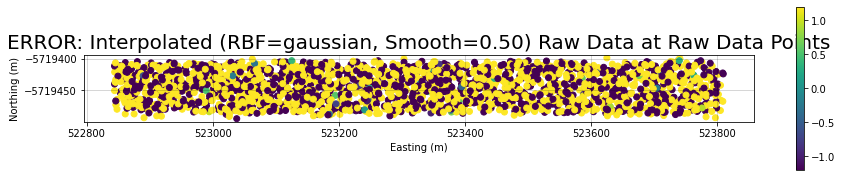

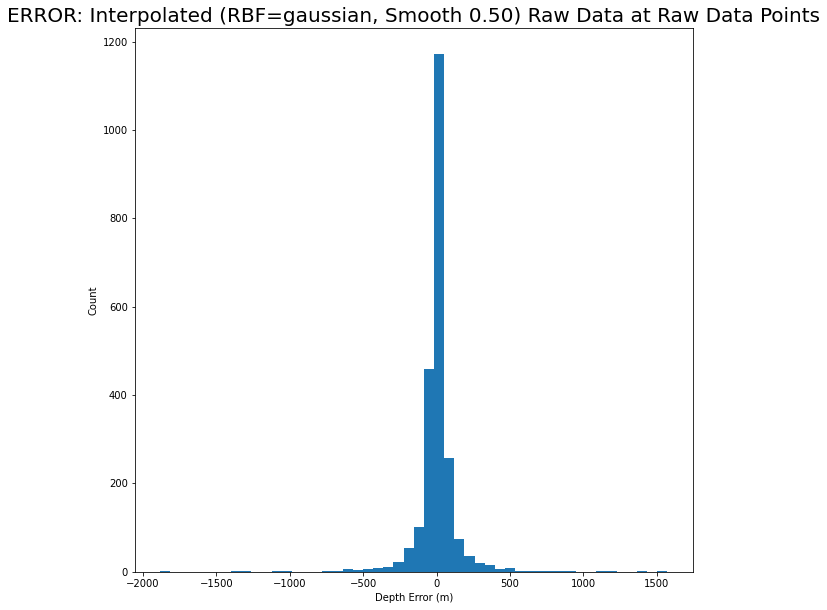

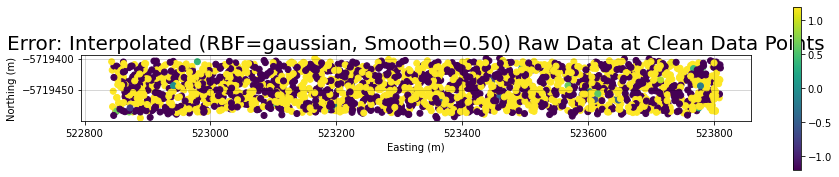

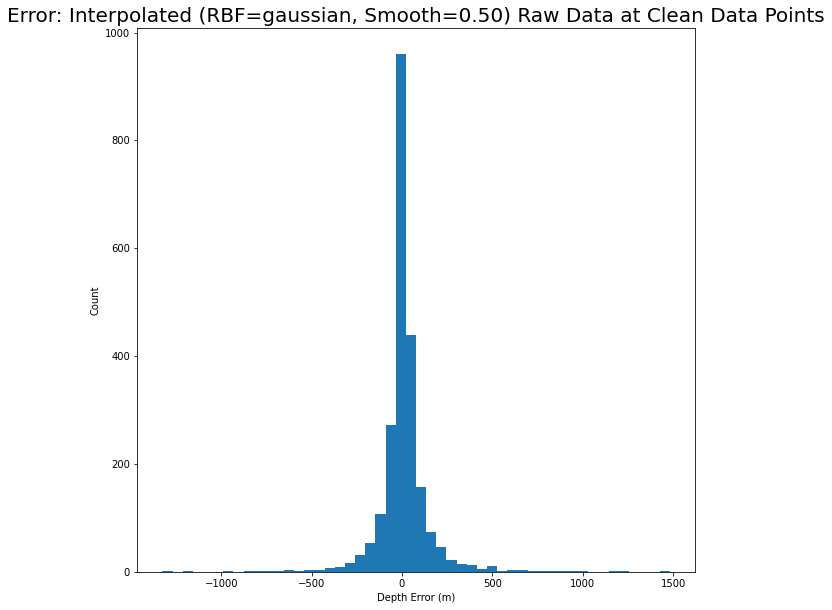

In [72]:
# Interpolate (RBF=Gaussian, Smooth=0.5) Subsampled, Raw Data:
full_rbf_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                  grid_x, grid_y, extent, vmin, vmax, tvu_order2, function='gaussian', smooth=0.5)


<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Interpolate subsampled (raw and cleaned) data: sklearn.gaussian_process with optional parameters:
##### --Equivalent to kriging.
------------------------------------------------------------

##### Interpolate (RBF, Gaussian Process Regressor; Alpha=0.1)

In [ ]:
full_gaussian_process_regressor_RBF(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                                    grid_x, grid_y, extent, vmin, vmax, tvu_order2, alpha=0.1)

##### Interpolate (RBF, Gaussian Process Regressor; Alpha=0.5)

In [ ]:
full_gaussian_process_regressor_RBF(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                                    grid_x, grid_y, extent, vmin, vmax, tvu_order2, alpha=0.5)

##### Interpolate (RBF, Gaussian Process Regressor; Alpha=1.0)

In [ ]:
full_gaussian_process_regressor_RBF(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                                    grid_x, grid_y, extent, vmin, vmax, tvu_order2, alpha=1.0)

##### Interpolate (RBF, Gaussian Process Regressor; Alpha=2.5)


ERROR: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Raw Data Points (alpha=2.50, length_scale=0.01)
Mean: 0.000000
Standard Deviation: 2.173062

ERROR: Interpolated (RBF, Gaussian Process Regressor) Raw Data at Clean Data Points (alpha=2.50, length_scale=0.01)
Mean: -0.360661
Standard Deviation: 1.053930


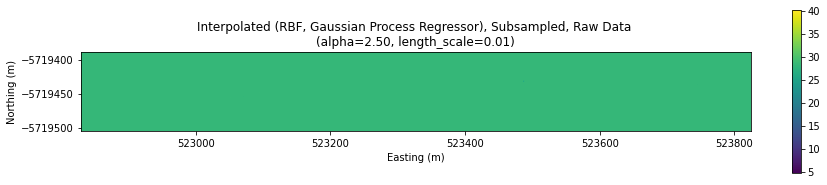

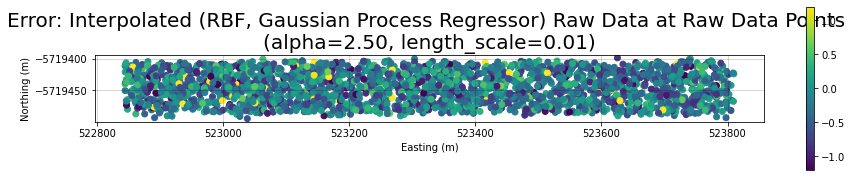

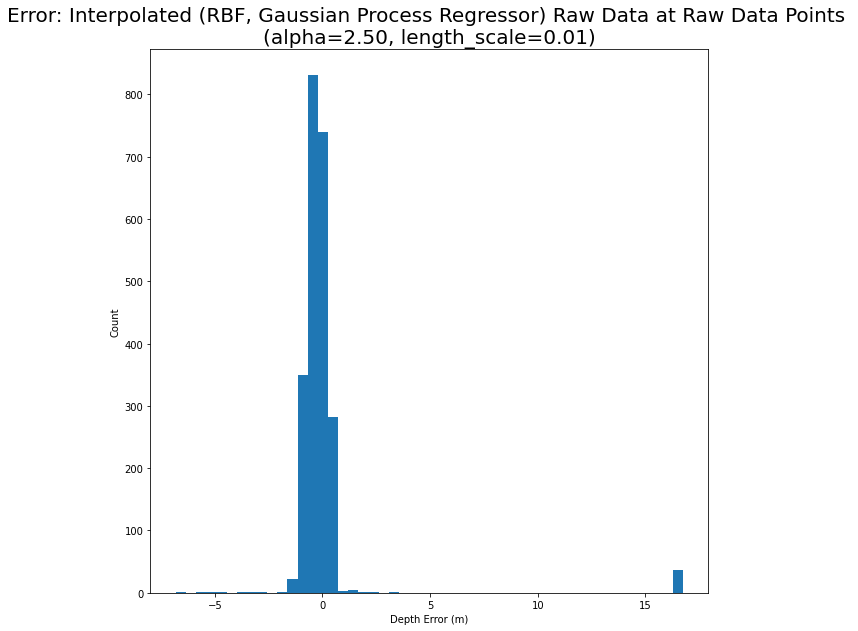

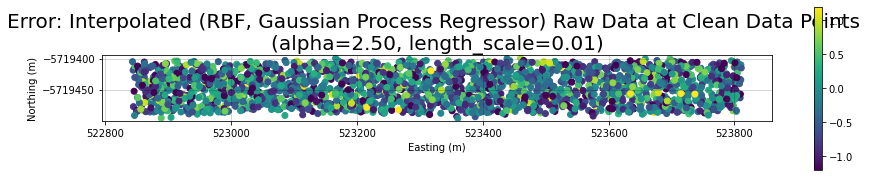

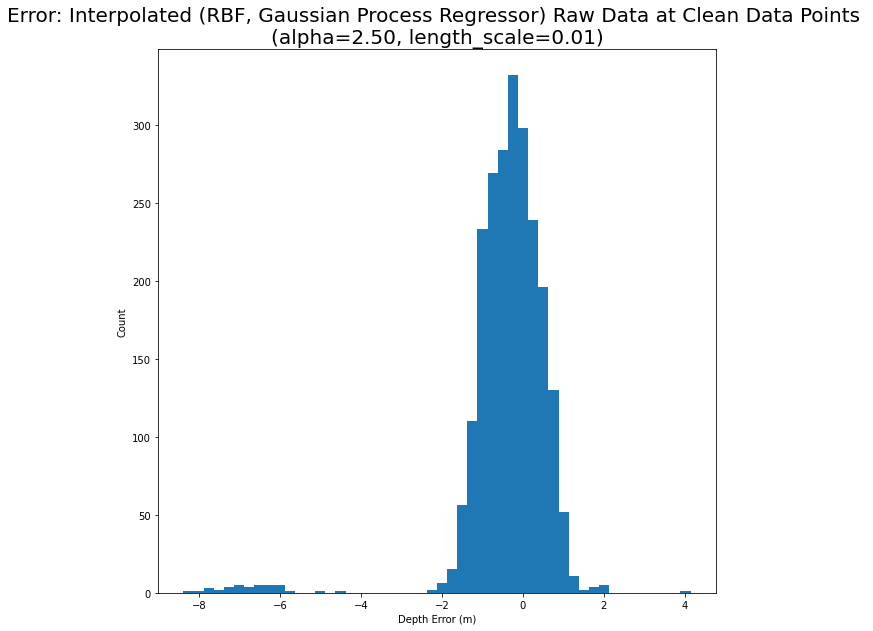

In [111]:
full_gaussian_process_regressor_RBF(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                                    grid_x, grid_y, extent, vmin, vmax, tvu_order2, alpha=2.5)


<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Interpolate subsampled (raw and cleaned) data: scipy.griddata(), with default parameters.
------------------------------------------------------------

In [79]:
# Using as a model: https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb
points = np.array([x_sub_raw.tolist(), y_sub_raw.tolist()]).T

##### Interpolate (method='nearest')

In [82]:
grid_z_nearest = griddata(points, z_sub_raw, (grid_x, grid_y), method="nearest")

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(grid_z_nearest, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
#ax.scatter(x_sub_raw, y_sub_raw, s=1, c='w')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Nearest Interpolation")
fig.colorbar(im, shrink=0.2);

##### Interpolate (method='linear')

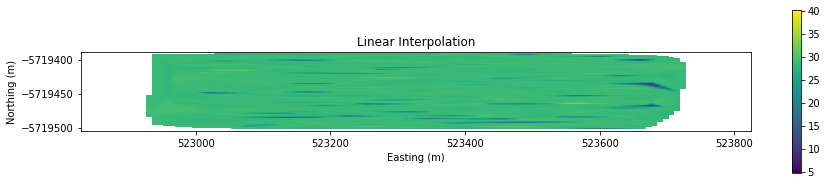

In [86]:
grid_z_linear = griddata(points, z_sub_raw, (grid_x, grid_y), method="linear")

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(grid_z_linear, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
#ax.scatter(x_sub_raw, y_sub_raw, s=1, c='w')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Linear Interpolation")
fig.colorbar(im, shrink=0.2);

##### Interpolate (method='cubic')

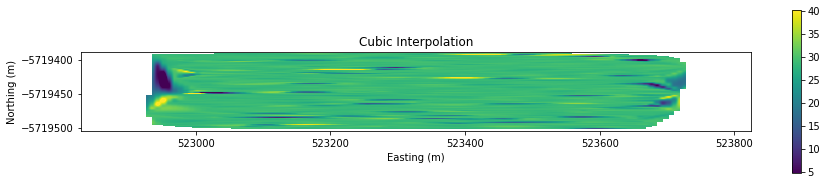

In [87]:
grid_z_cubic = griddata(points, z_sub_raw, (grid_x, grid_y), method="cubic")

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(grid_z_cubic, origin="lower", extent=extent, vmin=data["depth"].min(), vmax=data["depth"].max())
ax.ticklabel_format(useOffset=False, style='plain')
#ax.scatter(x_sub_raw, y_sub_raw, s=1, c='w')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Cubic Interpolation")
fig.colorbar(im, shrink=0.2);

Conclusions: Unsure how to compare these surfaces to 'ground truth'... No real conclusions.

<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
Interpolation with verde.Spline:
------------------------------------------------------------


Error: Interpolated (Verde Spline) Raw Data at Raw Data Points (mindist= 1  damping= 0.0001  spacing= None )
Mean: 28.312878
Standard Deviation: 3.042287

Error: Interpolated (Verde Spline) Raw Data at Clean Data Points 
(mindist= 1  damping= 0.0001  spacing= None )
Mean: 28.673539
Standard Deviation: 0.624358


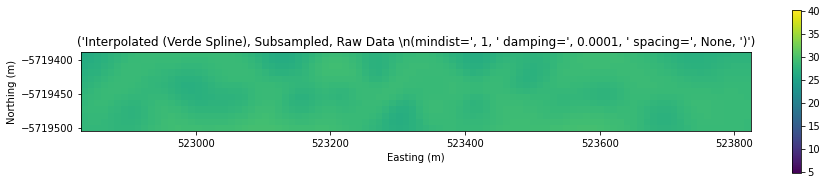

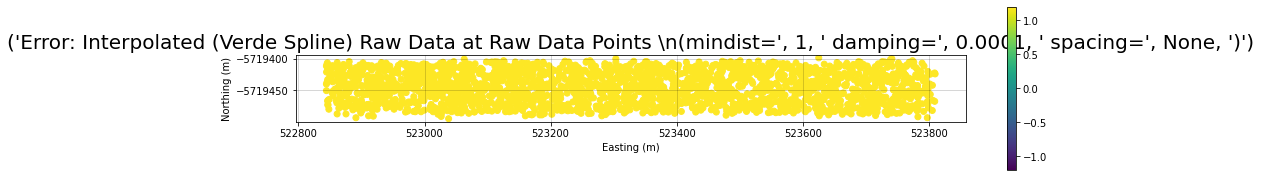

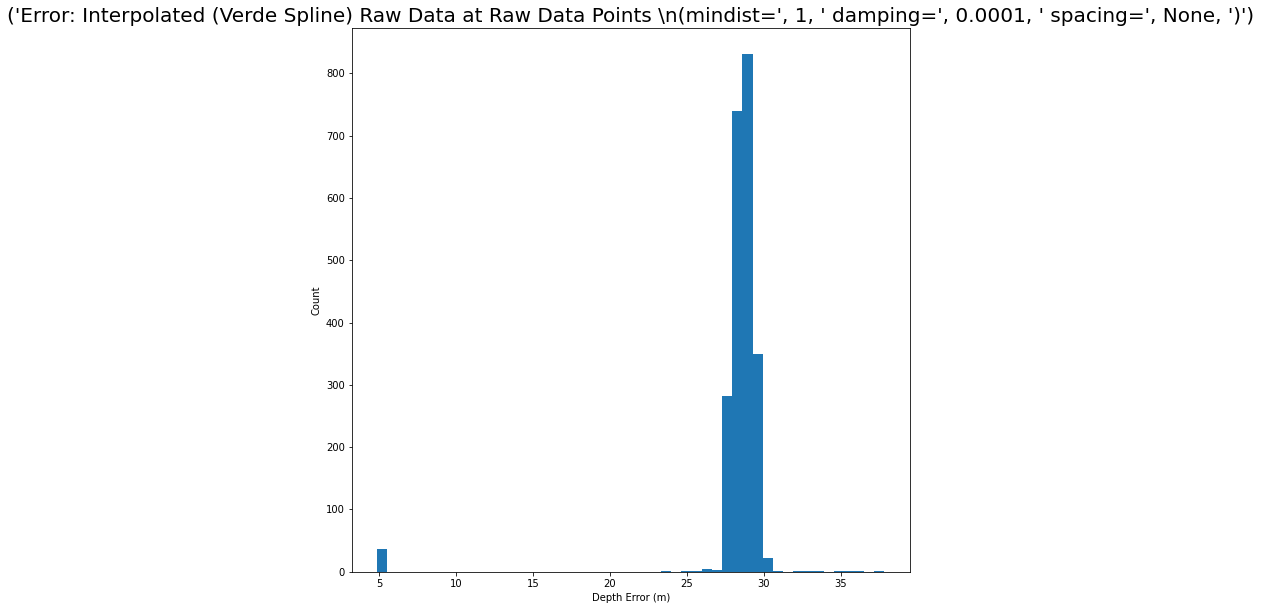

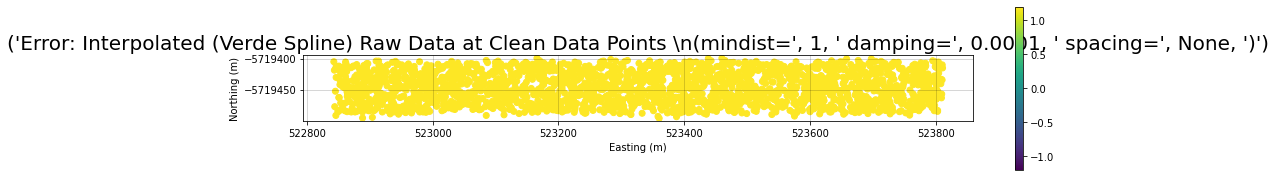

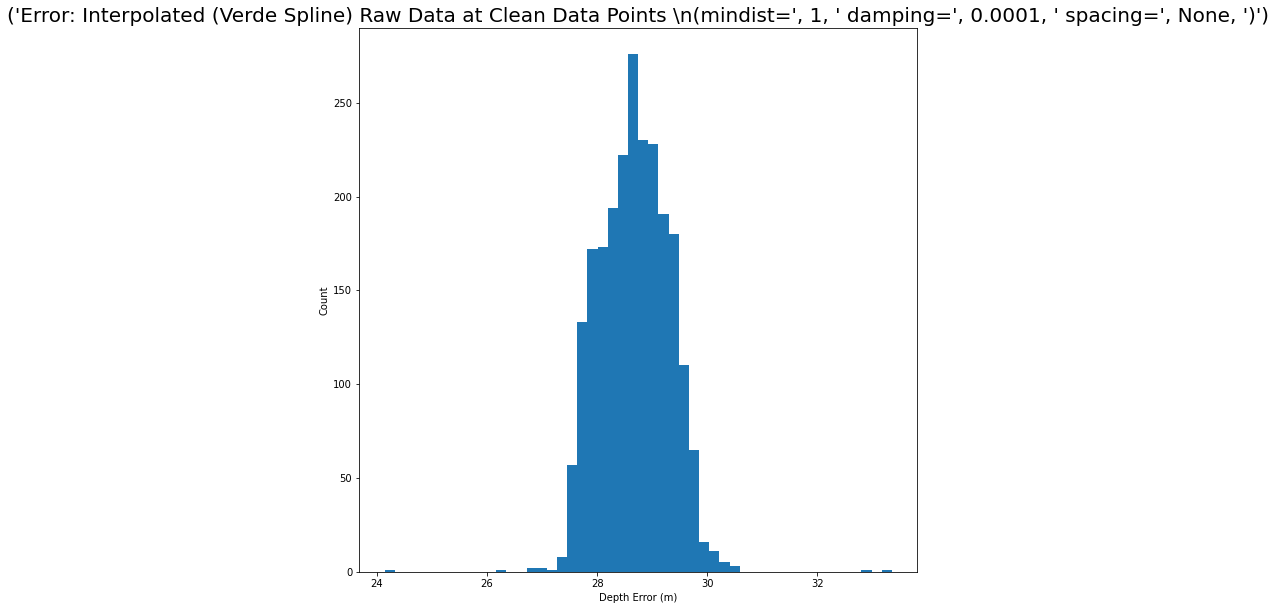

In [128]:
full_verde_spline_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                           extent, vmin, vmax, tvu_order2, mindist=1, damping=1e-4)


Error: Interpolated (Verde Spline) Raw Data at Raw Data Points (mindist= 10  damping= 0.0001  spacing= None )
Mean: 28.312878
Standard Deviation: 3.042287

Error: Interpolated (Verde Spline) Raw Data at Clean Data Points 
(mindist= 10  damping= 0.0001  spacing= None )
Mean: 28.673539
Standard Deviation: 0.624358


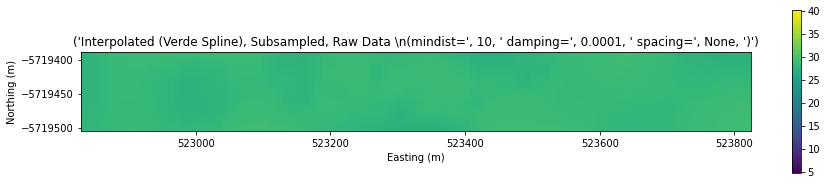

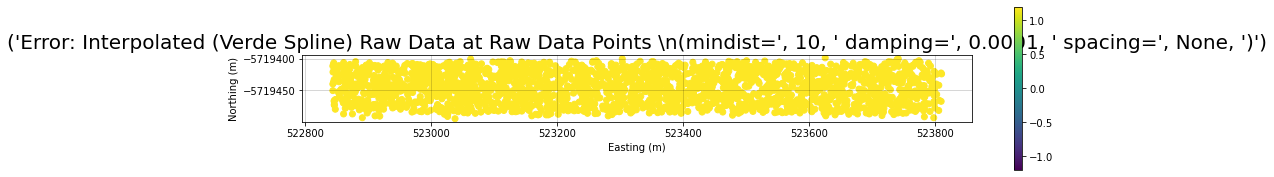

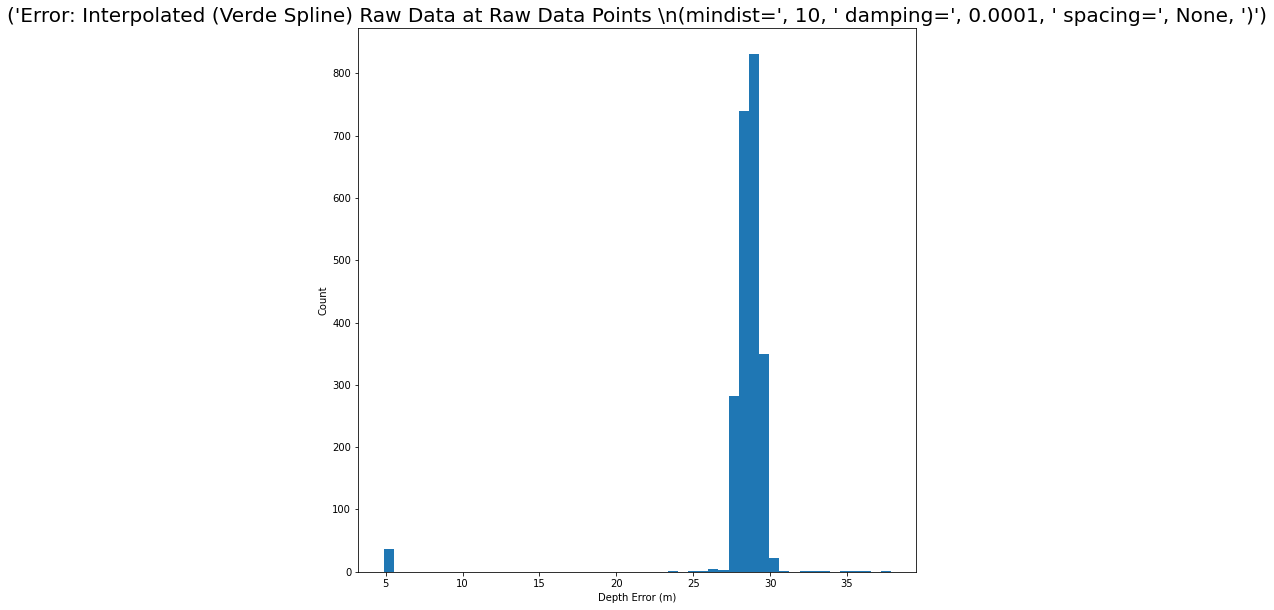

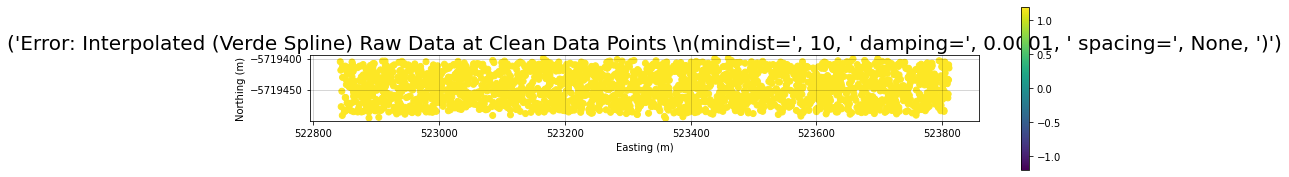

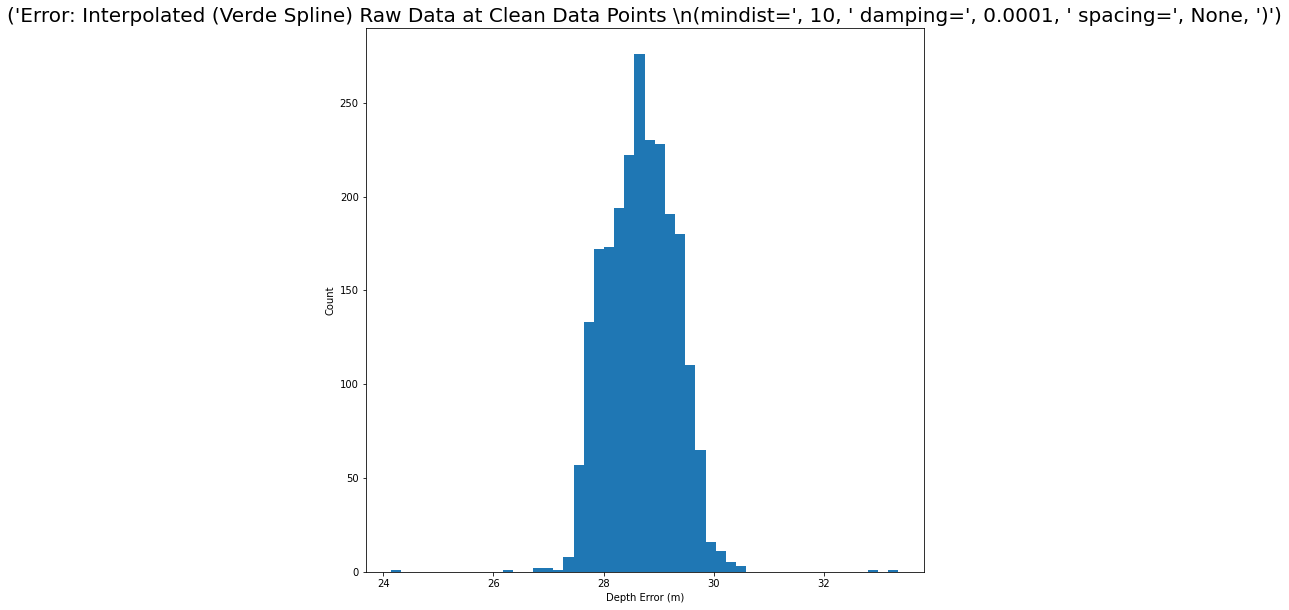

In [129]:
full_verde_spline_analysis(x_sub_raw, y_sub_raw, z_sub_raw, x_sub_clean, y_sub_clean, z_sub_clean,
                           extent, vmin, vmax, tvu_order2, mindist=10, damping=1e-4)

Conclusions: Cannot find parameters for this function that do not result in large mean errors! :(

<br>
<br>
<br>
<br>
<br>

------------------------------------------------------------
## Ordinary kriging using PyKrige package.
------------------------------------------------------------


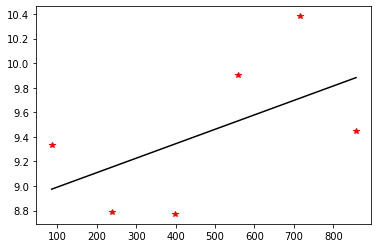

In [131]:
ordinary_kriging = OrdinaryKriging(x_sub_raw, y_sub_raw, z_sub_raw,
                                   variogram_model="linear", verbose=False, enable_plotting=False)
ordinary_kriging.display_variogram_model()

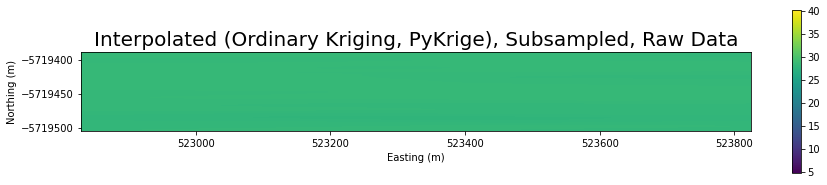

In [139]:
xpoints = np.arange(min(data["x"]), max(data["x"]), (max(data["x"]) - min(data["x"])) * 0.01)
ypoints = np.arange(min(data["y"]), max(data["y"]), (max(data["y"]) - min(data["y"])) * 0.01)

z, ss = ordinary_kriging.execute(style="grid", xpoints=xpoints, ypoints=ypoints)

fig, ax = plt.subplots(figsize=(15,15))
c1 = plt.imshow(z.T, origin="lower", extent=extent, vmin=vmin, vmax=vmax)
ax.set_aspect(1)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Interpolated (Ordinary Kriging, PyKrige), Subsampled, Raw Data", fontsize=20)
plt.colorbar(c1, shrink=0.2);

Conclusions: Hmm... I don't *entirely* understand what is happening here or how to compare results to 'ground truth.'
This requires having very few points to apply the kriging algorithm to (xpoints, ypoints) and runs into memory errors
even with (x_sub_clean, y_sub_clean) which, at the time of writing, represents only 1 of 1000 data points in the
cleaned dataset. This may be a lousy algorithm for that reason alone--that it requires such extreme subsampling.

<br>
<br>
<br>
<br>
<br>

# NOTES:

## Interpolation Methods:
Good resource on interpolation methods: https://www.gisresources.com/types-interpolation-methods_3/

## Kriging!
Kriging is a geostatistical interpolation technique that considers both the distance and the degree of variation
between known data points when estimating values in unknown areas. A kriged estimate is a weighted linear combination
of the known sample values around the point to be estimated.

Kriging procedure that generates an estimated surface from a scattered set of points with z-values. Kriging assumes
that the distance or direction between sample points reflects a spatial correlation that can be used to explain
variation in the surface. The Kriging tool fits a mathematical function to a specified number of points, or all points
within a specified radius, to determine the output value for each location. Kriging is a multistep process; it includes
exploratory statistical analysis of the data, variogram modeling, creating the surface, and (optionally) exploring a
variance surface. Kriging is most appropriate when you know there is a spatially correlated distance or directional
bias in the data. It is often used in soil science and geology.